<a href="https://colab.research.google.com/github/yahya010/DocClustering/blob/Ryan_Working/Optimized_OriginOfSpecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 pip install -U sentence-transformers cleanlab hdbscan umap umap-learn[plot] wordcloud gensim==3.8.3 --upgrade nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 65.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 40.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# mount google drive, sets folder for saving plots and figures, creates the folders if they do not exist
import os
from google.colab import drive

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/Saved_Figures_SD/WordClouds/'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Created directory {folder_path}")
else:
    print(f"Directory {folder_path} already exists")

Mounted at /content/drive
Directory /content/drive/MyDrive/Saved_Figures_SD/WordClouds/ already exists


In [ ]:
# Creates Timestamp variable for saving off results
import datetime

now = datetime.datetime.now()
timestamp = now.strftime("%Y-%m-%d")
print(timestamp)

2023-04-02


In [ ]:
# IMPORTS
from cleanlab.outlier import OutOfDistribution
from enum import Enum
import os
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from PIL import Image
 #from seg_algorithm import get_optimal_splits, get_segmented_sentences
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
from umap.umap_ import INT32_MAX
from wordcloud import WordCloud
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim import corpora
import gensim
from pprint import pprint
#from seg_algorithm import get_optimal_splits, get_segmented_sentences
import cleanlab
import hdbscan
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import sklearn.cluster as cluster
import string
import torch
import torch.nn.functional as F
import umap
import unicodedata
from gensim.models import KeyedVectors
from statistics import mean
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS
import csv
nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Constants
URL = "https://raw.githubusercontent.com/yahya010/DocClustering/main/Pres_Speeches/presidential_speeches.csv"
stop_words = set(stopwords.words('english')) # switched to sklearn as it is larger than nltk stopwords
dataset = ''
with open('OriginOfSpeeches.rtf', 'r') as file:
    dataset = file.read()

p = 0.65 #increase p = no of segments decreases

# Initialization
SEPERATE_BY_PRES = False

# Pre-Processing
MIN_SENTENCE_WORDS = 5
PLOT_SPEECHLEN_HIST = True
MIN_SPEECH_SENTENCE_COUNT = 10 # 10 sentences needed for cleanlab embedding

# Cleanlab
OUTLIER_SCORE_CUTOFF = 0.5
PRINT_CLEANLAB_ANALYSIS = True

# Lemmatize
num_lemmatized_words = 10

# Number of clusters - filtered
num_filtered_clusters = 32
num_unfiltered_clusters = 25

# Traffic control
coherenceRan_Filtered = False
initialWordcloudRan_Filtered = False
coherenceRan_Unfiltered = False
initialWordcloudRan_Unfiltered = False

# kmeans
kmeans_seed = 4  #By default kmeans seed is random, by setting the seed, the results are repeatable. 2^32 or 2^64 possible random states.

## REF: https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nlp_tf-idf_clustering.ipynb#scrollTo=EbAMAIFFV_xh

# List of Presidents
class PresidentIndex(Enum):
  George_Washington = 0
  John_Adams = 1
  Thomas_Jefferson = 2
  James_Madison = 3
  James_Monroe = 4
  John_Quincy_Adams = 5
  Andrew_Jackson = 6
  Martin_Van_Buren = 7
  William_Harrison = 8
  John_Tyler = 9
  James_Polk = 10
  Zachary_Taylor = 11
  Millard_Fillmore = 12
  Franklin_Pierce = 13
  James_Buchanan = 14
  Abraham_Lincoln = 15
  Andrew_Johnson = 16
  Ulysses_Grant = 17
  Rutherford_Hayes = 18
  James_Garfield = 19
  Chester_Arthur = 20
  Grover_Cleveland_1 = 21
  Benjamin_Harrison = 22
  Grover_Cleveland_2 = 23
  William_McKinley = 24
  Theodore_Roosevelt = 25
  William_Taft = 26
  Woodrow_Wilson = 27
  Warren_Harding = 28
  Calvin_Coolidge = 29
  Herbert_Hoover = 30
  Franklin_Roosevelt = 31
  Harry_Truman = 32
  Dwight_Eisenhower = 33 
  John_Kennedy= 34
  Lyndon_Johnson = 35
  Richard_Nixon = 36
  Gerald_Ford = 37
  James_Carter = 38
  Ronald_Reagan = 39
  George_H_W_Bush = 40
  Bill_Clinton = 41
  George_W_Bush = 42
  Barack_Obama = 43
  Donald_Trump = 44

# Set Presidents to use
PRESIDENTS = [PresidentIndex.Ronald_Reagan, PresidentIndex.George_H_W_Bush, PresidentIndex.Bill_Clinton, PresidentIndex.George_W_Bush, PresidentIndex.Barack_Obama, PresidentIndex.Donald_Trump];
PRESIDENT_NAMES = [n.name for n in PRESIDENTS]

# Get stopwords, stemmer and lemmatizer
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
general_stopwords = ENGLISH_STOP_WORDS  # note: sklearn has a longer list than nltk.corpus.stopwords.words('english')
additional_stopwords = []


# Get data samples and associated president
speeches = [dataset]
speech_classes = []

In [ ]:
def z_score(data):
    """Calculates the z-scores for a given dataset."""
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data - mean) / std_dev
    return z_scores

def squared_sum(x):
  """ return 3 rounded square rooted value """
  return round(np.sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

def color_func(word=None, font_size=None,
                     position=None, orientation=None,
                     font_path=None, random_state=None):
    colors = [[4, 77, 82],
              [25, 74, 85],
              [82, 43, 84],
              [158, 48, 79]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

# ------------------------------------------------------------------------------------------------
# Rishabhs Functions
# Get the final coherence scores for each cluster
def calcFinalScores(coherenceScores, finalWeights):
  listScores = []
  for i in range(len(coherenceScores)):
    sum = 0
    for j in range(len(coherenceScores[i])):
      sum += finalWeights[i][j]*coherenceScores[i][j]
    listScores.append(sum) # Multiply sum by 1000 to make scores more readable (this can be changed). Divide by 45 to get average. 
  return listScores


# Use temporary weights to get final weights. The weights will be finalized by normalizing them.

def calcFinalWeights(pairWeights):
  finalWeights = []
  for i in range(len(pairWeights)):
    curWeights = pairWeights[i]
    sumWeights = 0
    for j in range(len(curWeights)):
      # sumWeights = sumWeights + math.exp(curWeights[j])
      sumWeights = sumWeights + curWeights[j]
    tempFinalWeights = []
    for j in range(len(curWeights)):
      # tempFinalWeights.append(math.exp(curWeights[j]) / sumWeights)
      tempFinalWeights.append(curWeights[j] / sumWeights) # Normalize the weights
    finalWeights.append(tempFinalWeights)
  # sum = 0
  # for i in range(len(finalWeights[0])):
  #   sum = sum + finalWeights[1][i]

  return finalWeights

def calcCoherence1(clusterStrings):
  corpus = clusterStrings # set corpus as the list of clusters with corresponding texts as strings
  corpus = [' '.join(cluster) for cluster in clusterStrings]
  # Use TF-IDF
  vectorizer = TfidfVectorizer(stop_words=list(STOPWORDS), norm=None, smooth_idf=False) 
  X = vectorizer.fit_transform(corpus)
  idf = vectorizer.idf_
  idf = idf - 1
  countVectorizer = CountVectorizer(stop_words=list(STOPWORDS))
  tf = countVectorizer.fit_transform(corpus)
  tf = tf.toarray()
  tfidf = tf*idf

  lemmatizer = WordNetLemmatizer()
  coherenceScores = []
  pairWeights = []

  for i in range(len(clusterStrings)): # loop through all clusters

    df = pd.DataFrame(tfidf[i], index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
    dfs = df.sort_values('TF-IDF', ascending=False) 

    curList = dfs.index.to_list()
    curListLem = []
    curList10 = []

    # Get top 10 words (lemmatized)
    w = 0
    c = 0
    while c < num_lemmatized_words:
      word = curList[w]
      curWord = lemmatizer.lemmatize(word)
      if curWord not in curListLem and curWord in model.vocab:
        curListLem.append(curWord)
        c = c + 1
      w = w + 1

    # Get pair-wise scores
    tempScore = []
    tempPairWeights = []
    for a in range(len(curListLem)):
      for b in range(a, len(curListLem)):
        if a != b:
          w1 = curListLem[a]
          w2 = curListLem[b]
          weight1 = list(model.vocab.keys()).index(w1) # Get Zipf rank of word 1
          weight2 = list(model.vocab.keys()).index(w2) # Get Zipf rank of word 2
          tempPairWeights.append(mean([weight1, weight2]))
          # tempPairWeigts.append(math.log(weight1, 10) + math.log(weight2, 10) / 2)
          tempScore.append(model.similarity(w1, w2))
    pairWeights.append(tempPairWeights)
    coherenceScores.append(tempScore)
  return [pairWeights, coherenceScores] # return list of weights and temporary scores
# wrapper function to calculate coherence scores

def calcCoherence(clusterStrings):
  pairWeights_and_coherenceScores1 = calcCoherence1(clusterStrings)
  pairWeights = pairWeights_and_coherenceScores1[0]
  coherenceScores1 = pairWeights_and_coherenceScores1[1]
  finalWeights = calcFinalWeights(pairWeights)
  finalScores = calcFinalScores(coherenceScores1, finalWeights)
  return finalScores
# ------------------------------------------------------------------------------------------------

Number of Speeches Processed: 1
Filtered 0 speeches (under 10 sentences in total length)


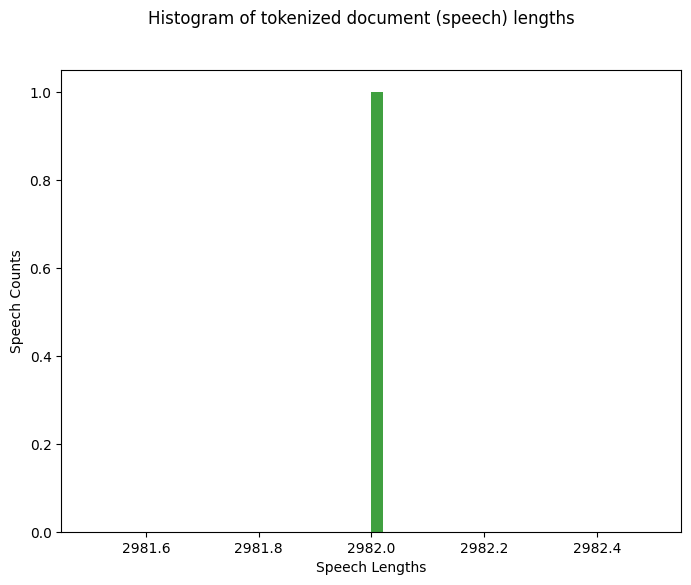

In [ ]:
# Pre-Processing

pre_processed_speeches = []
list_token_lists = []
unfiltered_sentences = []

exclude = string.punctuation.replace(".", "")
exclude = exclude.replace("!", "")
exclude = exclude.replace("?", "")

# Pre-Processing Helpers
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")
  
def remove_misc(data):
  return data.replace('\n', '')

stop_words = set(stopwords.words('english'))
speech_lengths = []




for i, speech in enumerate(speeches):
  
  # Tokenize by sentence, then by lowercase word
  sent_count = 0
  pre_processed_speech_index = []

  for sentence in nltk.sent_tokenize(speech):
    token_list = []
    unfiltered_sentences.append(sentence)
    
    if len(nltk.word_tokenize(sentence)) < MIN_SENTENCE_WORDS:
      continue

    tokens = []
    sent_count += 1

    for word in nltk.word_tokenize(sentence):
      t = word.lower()
      t = remove_accents(t)
      t = remove_misc(t)
      t = str(t).translate(string.punctuation)
      t = t.translate(str.maketrans('', '', exclude))

      token_list.append(t)

    pre_processed_speech_index.append(' '.join(token_list)) # tokenized sentences
  
  if sent_count >= MIN_SPEECH_SENTENCE_COUNT:
    speech_lengths.append(sent_count)
    pre_processed_speeches.append(pre_processed_speech_index)
  
print(f'Number of Speeches Processed: {len(pre_processed_speeches)}')
print(f'Filtered {len(speeches) - len(pre_processed_speeches)} speeches (under 10 sentences in total length)')

df_speeches = pd.DataFrame(list_token_lists)

# Plot histogram of tokenized document lengths
if PLOT_SPEECHLEN_HIST:
  fig = plt.figure(figsize=(8,6))
  plt.suptitle("Histogram of tokenized document (speech) lengths")
  plt.xlabel("Speech Lengths")
  plt.ylabel("Speech Counts")
  n, bins, patches = plt.hist(speech_lengths, bins=50, density=False, facecolor='g', alpha=0.75)
  plt.show()

In [ ]:
# Running Cleanlab WITH cleanlab score removal
# Filters unrelated sentences from each individual speech

# Filtered speeches = list of every useful sentence across every speech of the selected president(s)
post_cleanlab_speeches = []
post_cleanlab_sentences = []

all_cleanlab_scores = []

# Embedding and outlier removal
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

filtered_sent_percentages = []

for i, speech in enumerate(pre_processed_speeches):
  try:
    ood = OutOfDistribution()
    original_embeddings = model.encode(speech)
    train_outlier_scores = ood.fit_score(features=original_embeddings)
    # get outlier id's for sentences with outlier scores below cutoff value
    outlier_ids = [i for i, outlier_score in enumerate(train_outlier_scores) if outlier_score < OUTLIER_SCORE_CUTOFF]

    if PRINT_CLEANLAB_ANALYSIS:
      filtered_sentences = [s for i, s in enumerate(speech) if i in outlier_ids]
      filtered_percent = round((len(filtered_sentences) / len(speech)) * 100) 
      filtered_sent_percentages.append(filtered_percent)

      # Metrics
      
      average_cleanlab_score = float(np.mean(train_outlier_scores))
      variance_cleanlab_score = float(sum((x - average_cleanlab_score)**2 for x in train_outlier_scores) / (len(train_outlier_scores) - 1))
      std_cleanlab_score = float(np.sqrt(variance_cleanlab_score))
      min_cleanlab_score = float(min(train_outlier_scores))
      max_cleanlab_score = float(max(train_outlier_scores))

      all_cleanlab_scores.extend(train_outlier_scores)
      
      print(f'Speech: {i}')
      print("Cleanlab Metrics:")
      print(f'  Percent Sentences Filtered: {filtered_percent}% out of {len(speech)} Sentences')
      print(f'  Average: {round(average_cleanlab_score, 3)}')
      print(f'  Variance: {round(variance_cleanlab_score, 3)}')
      print(f'  STDev: {round(std_cleanlab_score, 3)}')
      print(f'  Min: {round(min_cleanlab_score, 3)}')
      print(f'  Max: {round(max_cleanlab_score, 3)}')
      print("Filtered Sentences:")
      for i, s in enumerate(filtered_sentences):
        print(f'  {i}: {s}')
      print("\n\n")

    speech_cleanlab = [s for i, s in enumerate(speech) if i not in outlier_ids]

    post_cleanlab_speeches.append(speech_cleanlab)

    for sentence in speech_cleanlab:
      post_cleanlab_sentences.append(sentence)
  except:
    continue

print(f'Cleanlab score: {all_cleanlab_scores}')

filtered_speech_embeddings = model.encode(post_cleanlab_sentences) # embedding
unfiltered_speech_embeddings = model.encode(unfiltered_sentences) 


# if PRINT_CLEANLAB_ANALYSIS:
#   # print(f'Unfiltered Speech Shape: {model.encode(pre_processed_speeches).shape}') vcc
#   print(f'Filtered Speech Shape: {filtered_speech_embeddings.shape}')
#   print(f'Filtered Speech Shape Z Score: {filtered_speech_embeddings_z_score.shape}')
#   print(f'Average percentage of filtered sentences per speech (cutoff value  of {OUTLIER_SCORE_CUTOFF}): {sum(filtered_sent_percentages) / len(filtered_sent_percentages)}')
#   print(f'Average percentage of filtered z score sentences per speech (cutoff value  of {Z_SCORE_CUTOFF}): {sum(filtered_sent_percentages_z_score) / len(filtered_sent_percentages_z_score)}')

Fitting OOD estimator based on provided features ...
Speech: 0
Cleanlab Metrics:
  Percent Sentences Filtered: 0% out of 2982 Sentences
  Average: 0.686
  Variance: 0.004
  STDev: 0.06
  Min: 0.442
  Max: 0.854
Filtered Sentences:
  0:  rtfansiansicpgcocoartf cocoatextscalingcocoaplatform  fonttblffmodernfcharset courier    colortbl  redgreenblue  redgreenblue      expandedcolortbl   cssrgbccc   marglmargrviewwviewhviewkind deftab pardpardeftabpartightenfactor ffs cf expndexpndtwkerning outlstrokewidth strokec when on board hms 
  1: so it is in india 
  2: how short his time 
  3: i do not believe so 
  4: brewer  that this is a mistake 
  5: why should this be so 
  6: affinities  general   complex and radiating 
  7: this i feel sure  and i speak after experience  will be no slight relief 



Cleanlab score: [0.46590385, 0.64390826, 0.68157065, 0.5792106, 0.61938626, 0.58134466, 0.616596, 0.6121044, 0.6218263, 0.6052994, 0.65191513, 0.64439034, 0.67016655, 0.67050266, 0.745311, 0.71

In [ ]:
      all_z_scores = z_score(all_cleanlab_scores)
      average_cleanlab_score = float(np.mean(all_cleanlab_scores))
      variance_cleanlab_score = float(sum((x - average_cleanlab_score)**2 for x in all_cleanlab_scores) / (len(all_cleanlab_scores) - 1))
      std_cleanlab_score = float(np.sqrt(variance_cleanlab_score))
      min_cleanlab_score = float(min(all_cleanlab_scores))
      max_cleanlab_score = float(max(all_cleanlab_scores))
      average_z_score = float(np.mean(all_z_scores))
      variance_z_score = float(sum((x - average_z_score)**2 for x in all_z_scores) / (len(all_z_scores) - 1))
      std_z_score = float(np.sqrt(variance_z_score))
      min_z_score = float(min(all_z_scores))
      max_z_score = float(max(all_z_scores))
      print("Cleanlab Metrics:")
      print(f'  Average: {round(average_cleanlab_score, 3)}')
      print(f'  Variance: {round(variance_cleanlab_score, 3)}')
      print(f'  STDev: {round(std_cleanlab_score, 3)}')
      print(f'  Min: {round(min_cleanlab_score, 3)}')
      print(f'  Max: {round(max_cleanlab_score, 3)}')
      print("Cleanlab with Z Score Metrics:")
      print(f'  Average: {round(average_z_score, 3)}')
      print(f'  Variance: {round(variance_z_score, 3)}')
      print(f'  STDev: {round(std_z_score, 3)}')
      print(f'  Min: {round(min_z_score, 3)}')
      print(f'  Max: {round(max_z_score, 3)}')

Cleanlab Metrics:
  Average: 0.686
  Variance: 0.004
  STDev: 0.06
  Min: 0.442
  Max: 0.854
Cleanlab with Z Score Metrics:
  Average: -0.0
  Variance: 1.0
  STDev: 1.0
  Min: -4.084
  Max: 2.819


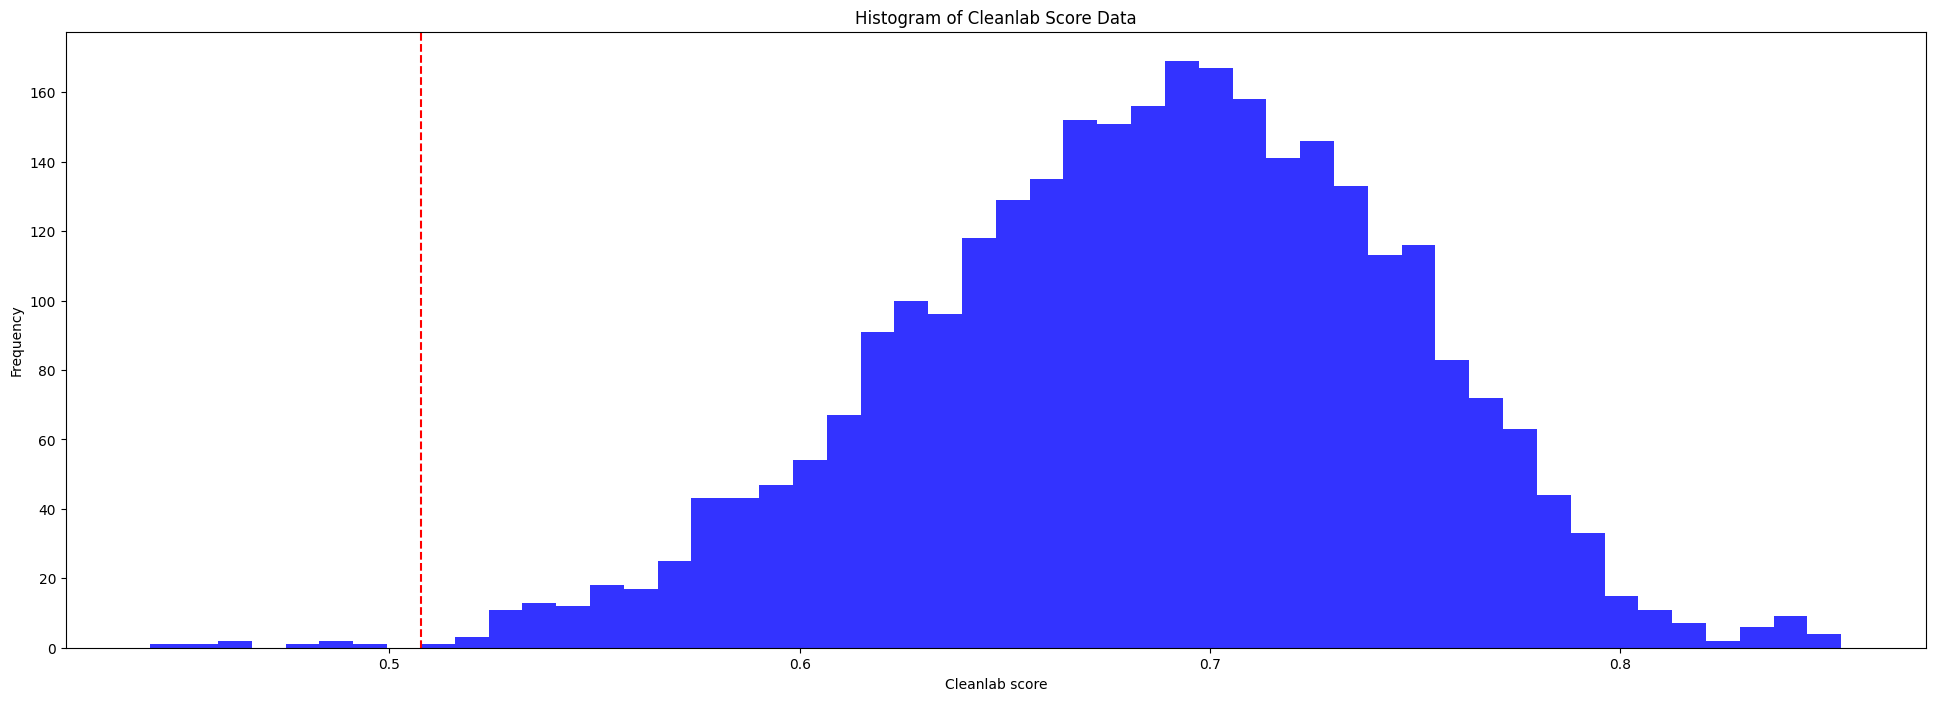

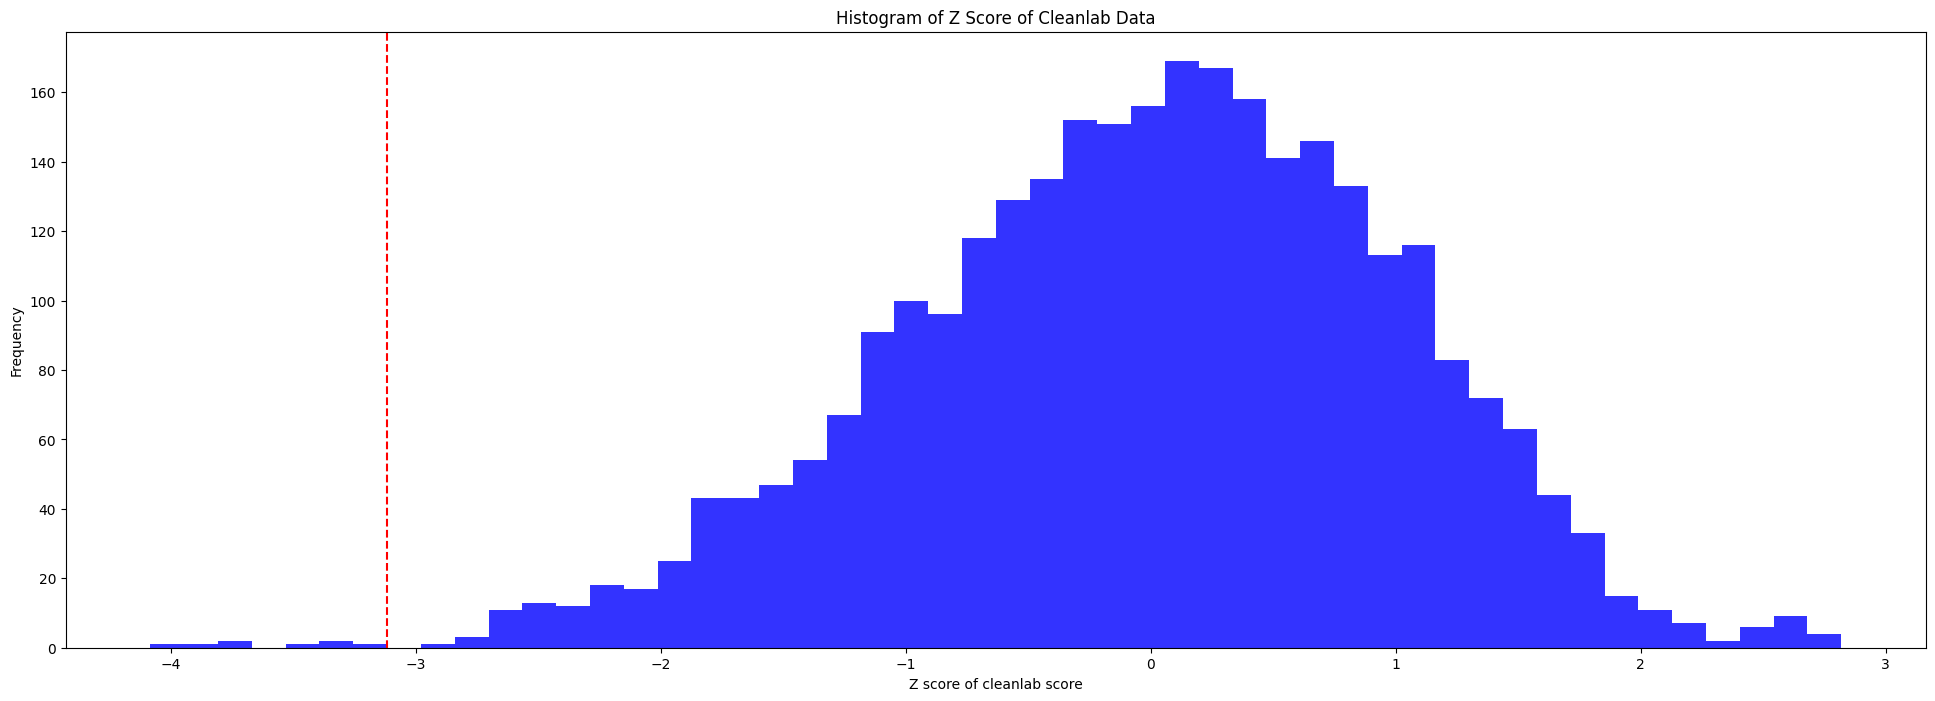

Cleanlab
  Smallest Cleanlab Number Score: 0.5
  Percent Filtered Out: 0.27%
Z Score
  Smallest Z Score Number Score: -3.128
  Percent Filtered Out: 0.23%


In [ ]:
# Cleanlab and Z score Histogram

cleanlab_histogram_cutoff = OUTLIER_SCORE_CUTOFF
num_bins = 50

# Cleanlab Histogram
fig = plt.figure(figsize=(24, 8))
n, bins, patches = plt.hist(all_cleanlab_scores, bins=num_bins, color='blue', alpha=0.8) # alpha is transparency of bars
sorted_data = np.sort(all_cleanlab_scores)
count = len([x for x in sorted_data if x < cleanlab_histogram_cutoff])
# val = np.min(sorted_data[n_smallest_num - 1])
idx = np.searchsorted(bins, cleanlab_histogram_cutoff, side='left')
x = bins[idx]
plt.axvline(x=x, color='red', linestyle='--')
# plt.xlim(6,14)  # Limits x axis range
# plt.ylim(0,10)  # Limits y axis range
plt.xlabel('Cleanlab score')
plt.ylabel('Frequency')
plt.title('Histogram of Cleanlab Score Data')
# plt.xlim(3,15)  # Limits x axis range
# plt.ylim(0,16)  # Limits y axis range
# for i in range(len(patches)):
#     plt.text(patches[i].get_x() + patches[i].get_width()/2.0, patches[i].get_height(),
#              int(n[i]), ha='center', va='bottom')
plt.show()

# Cleanlab with Z Score Histogram
fig = plt.figure(figsize=(24, 8))
n, bins, patches = plt.hist(all_z_scores, bins=num_bins, color='blue', alpha=0.8) # alpha is transparency of bars
sorted_data = np.sort(all_z_scores)
z_score_histogram_cutoff = np.min(sorted_data[count - 1])
z_score_count = len([x for x in sorted_data if x < z_score_histogram_cutoff])
idx = np.searchsorted(bins, z_score_histogram_cutoff, side='left')
x = bins[idx]
plt.axvline(x=x, color='red', linestyle='--')
# plt.xlim(6,14)  # Limits x axis range
# plt.ylim(0,10)  # Limits y axis range
plt.xlabel('Z score of cleanlab score')
plt.ylabel('Frequency')
plt.title('Histogram of Z Score of Cleanlab Data')
# for i in range(len(patches)):
#     plt.text(patches[i].get_x() + patches[i].get_width()/2.0, patches[i].get_height(),
#              int(n[i]), ha='center', va='bottom')
plt.show()
print(f'Cleanlab')
print(f'  Smallest Cleanlab Number Score: {cleanlab_histogram_cutoff}')
print(f'  Percent Filtered Out: {round(float((count/len(all_cleanlab_scores))*100),2)}%')

print(f'Z Score')
print(f'  Smallest Z Score Number Score: {round(float(z_score_histogram_cutoff),3)}')
print(f'  Percent Filtered Out: {round(float((z_score_count/len(all_z_scores))*100),2)}%')


In [ ]:
# PCA-95 Dimensionality Reduction
pca = PCA(n_components=0.95)
reduced_embedding = pca.fit_transform([f for f in filtered_speech_embeddings])  # filtered speech embedding is using post_cleanlab_sentences variable
reduced_unfiltered_embedding = pca.fit_transform([f for f in unfiltered_speech_embeddings])
print(reduced_embedding.shape)
print(reduced_unfiltered_embedding.shape)

(2974, 259)
(3002, 261)


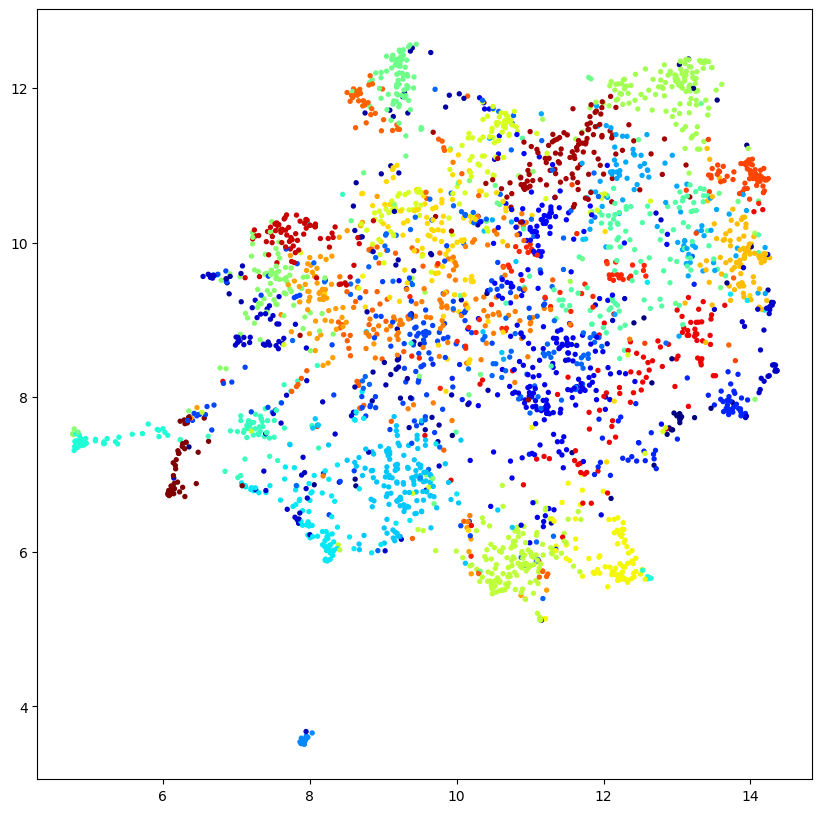

(2974, 259)
32


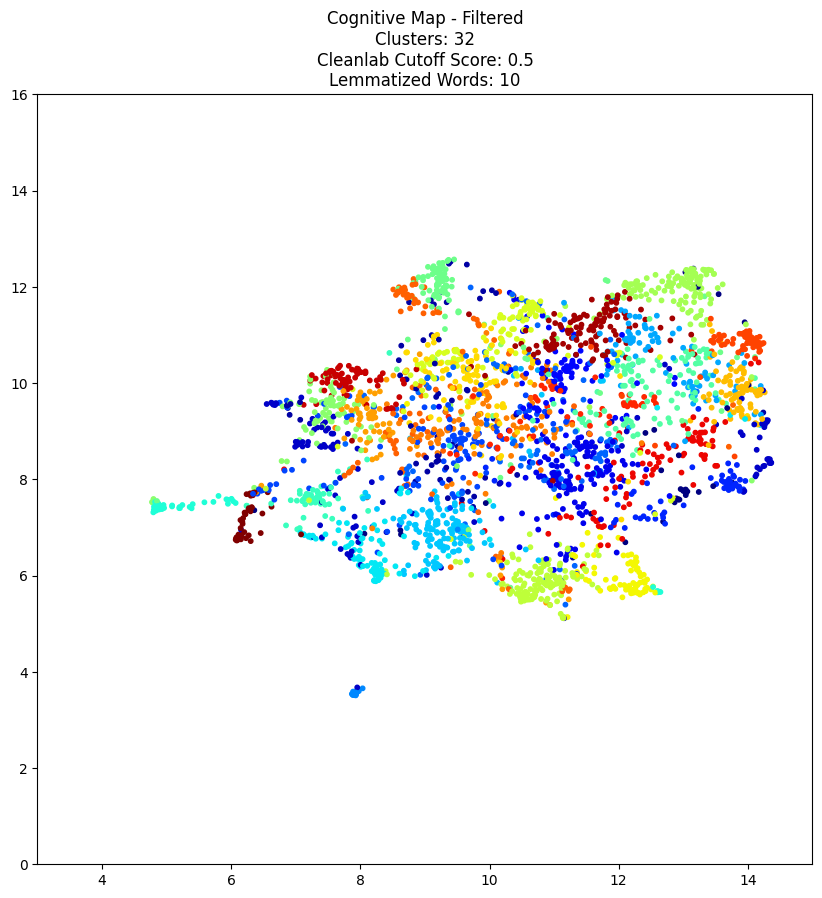

In [ ]:
# Filtered UMAP Clustering
reducer = umap.UMAP(n_components=2)
sentences_embeddings_reduced = reducer.fit_transform(reduced_embedding)

# Apply KMeans clustering to the reduced embeddings
n_clusters = num_filtered_clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=kmeans_seed)
kmeans.fit(reduced_embedding)

# Get the cluster labels for each sentence and plot
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(10, 10))
# plt.title("Cognitive Map: Cleanlab Filtered")
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels, cmap='jet', s=8) # s = dot size, cmap variables include cmap = 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# plt.xlim(6,14)  # Limits x axis range
# plt.ylim(0,10)  # Limits y axis range

kmeans_labels_sorted_data = [[] for i in range(n_clusters)]
embeddings_by_cluster = [[] for i in range(n_clusters)]
for i, label in enumerate(labels):
  kmeans_labels_sorted_data[label].append(i)
  embeddings_by_cluster.append(reduced_embedding[i])

plt.show()

# Does the two dimensions just represent the visual cluster comparison? KMeans is nonlinear

print(reduced_embedding.shape)
print(kmeans.n_clusters)
# Concentrated UMAP Plot
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(10, 10))
plt.title("Cognitive Map - Filtered" + "\nClusters: {}".format(n_clusters) + "\nCleanlab Cutoff Score: {}".format(OUTLIER_SCORE_CUTOFF)+ "\nLemmatized Words: {}".format(num_lemmatized_words))
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels, cmap='jet', s=10) # s = dot size, cmap variables include cmap = 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.xlim(3,15)  # Limits x axis range
plt.ylim(0,16)  # Limits y axis range
plt.show()

In [43]:
# ADD WORD CLOUD CODE
#Filtered
# Word Cloud
#Original method - probably using this

n_clusters = num_filtered_clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=kmeans_seed)
kmeans.fit(reduced_embedding)
labels = kmeans.labels_
num_sentences_all = []

# Add in when stop words is needed
additional_stopwords = ['thank','may', 'act', 'will', 'good', 'make', 'get', 'need', 'got', 'one', 'day', 'going', 'want', 'many', 'must', 'well', 'thing',
                        'say','new', 'much', 'still', 'first', 'ago', 'bad', 'next', 'yet', 'way', 'saw', 'big', 'know', 'keep', 'use', 'part', 'mean'
                        'tell', 'america', 'american', 'united states', 'us', 'usa', 'long', 'let', 'great', 'said', 'think', 'put', 'nation', 'hard'
                        'man', 'ask', 'people', 'time', 'year', 'back', 'went', 'years', 'came']
stop_words = set(stopwords.words('english'))
stop_words.update(additional_stopwords)

# List of tokenized sentences
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(post_cleanlab_sentences)

# Get the words and their tf-idf scores
feature_names = tfidf_vectorizer.get_feature_names_out()
scores = tfidf_matrix.toarray().mean(axis=0)

# Sort the words by their tf-idf scores
sorted_words = sorted(zip(feature_names, scores), key=lambda x: x[1])

lowest_tfidf_words = []
for word, score in sorted_words[:50]:
    lowest_tfidf_words.append(word)
#     print(f"{word}: {score:.4f}")
print(lowest_tfidf_words)

full_cluster_sentences = []
#labels = kmeans.labels_



for i in range(20):

    # Get the indices of sentences belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]
    cluster_sentences = [post_cleanlab_sentences[index] for index in cluster_indices]
    full_cluster_sentences.append(cluster_sentences)
    num_sentences = len(cluster_sentences)
    num_sentences_all.append(num_sentences)
    # Combine the sentences into a single string
    cluster_text = " ".join(cluster_sentences)
    cluster_text =" ".join([ word for word in cluster_text.split() if word.lower() not in lowest_tfidf_words and len(word)>2 and word.lower() not in stop_words])
    
    if coherenceRan_Filtered:
       # Generate a word cloud from the cluster text
      wordcloud = WordCloud(max_words=120, width=800, height=800, min_font_size=10, collocations=True, background_color="white").generate(cluster_text)

      # Creates a dictionary of words used in each wordcloud
      # text_dictionary = wordcloud.process_text(cluster_text)
      # word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
      # rel_freq=wordcloud.words_
      # print(list(word_freq.items())[:10])
      # print(list(rel_freq.items())[:10])

      wordcloud.generate(cluster_text)

      # Plot the word cloud
      fig = plt.figure(figsize=(8, 8))
      plt.figure(figsize=(8, 8), facecolor='white')
      # plt.title("Cluster:{}".format(i)) # comment after the coherence scores are ran
      plt.title("Cluster:{}".format(i) + "\nCoherence Score:{}".format(out[i]) + "\n# of Sentences in Cluster:{}".format(num_sentences)) # comment when ran initially
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.tight_layout(pad=0)
      # plt.show()

      file_name = f'{timestamp}_{OUTLIER_SCORE_CUTOFF}_{num_lemmatized_words}_Filtered_cluster_{i}_wordcloud.png'
      plt.savefig(folder_path + file_name, dpi=300)
      plt.show()

    
initialWordcloudRan_Filtered = True
num_sentences_all_DF = pd.DataFrame(num_sentences_all)
num_sentences_all_DF.to_csv('num_sentences_all_DF.csv')

['kindsthe', 'scarcity', 'chaptersin', 'differentthe', 'located', 'readiest', 'cephalopodic', 'inactive', 'wormlike', 'homologise', 'kindvertebre', 'otherhave', 'geometer', 'asparagus', 'berries', 'hazelnuts', 'helosciadium', 'blooddescendants', 'chaptersi', 'incalculable', 'aborigines', 'numbersin', 'gnathodon', 'intercalated', 'marched', 'fellowlabourers', 'prolong', 'dezertas', 'lulls', 'necessitating', 'shines', 'twentythree', 'hillvariety', 'interposition', 'steadiness', 'concurring', 'credible', 'feline', 'fieldmice', 'intervention', 'thirds', 'towns', 'villages', 'anagallis', 'arvensis', 'coerulea', 'impaired', 'pimpernels', 'barberry', 'camelhair']


In [ ]:
#Filtered coherence scores output

if(initialWordcloudRan_Filtered):
  out = calcCoherence(full_cluster_sentences)
  print(out)
  print(sum(out)/len(out))
  out_DF = pd.DataFrame(out)
  file_name = f'{timestamp}_coherence_scores_Filtered_{OUTLIER_SCORE_CUTOFF}_{num_lemmatized_words}_n{num_filtered_clusters}.csv'
  # out_DF.to_csv(folder_path + file_name)
  coherenceRan_Filtered = True

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


AttributeError: ignored

In [ ]:
#Plot descending coherence score values
# Filtered
fig = plt.figure(figsize=(24, 8))
sorted_values = sorted(out, reverse=True)
labels_bar = ['{}'.format(i+1) for i in range(len(out))]
plt.bar(labels_bar, sorted_values)
for i, out in enumerate(sorted_values):
    plt.text(i, out, round(out,3), ha='center', va='bottom')
plt.xlabel('Cluster bars')
plt.ylabel('Coherence score')
plt.title('Coherence Score Ranking; Descending Order')
plt.show()

NameError: ignored

<Figure size 2400x800 with 0 Axes>

In [ ]:
#  coherence score graph (changes n_clusters)
#Filtered
coherence_score_avgs = []
for x in range(1,50):
  kmeans = KMeans(n_clusters = x, n_init=10, random_state=kmeans_seed)
  kmeans.fit(reduced_embedding)
  # print(reduced_embedding.shape)
  full_cluster_sentences_temp = []
  labels = kmeans.labels_
  for i in range(kmeans.n_clusters): # 10 clusters now
      # Get the indices of sentences belonging to the current cluster
      cluster_indices = np.where(labels == i)[0]
      # print(cluster_indices)
      cluster_sentences = [post_cleanlab_sentences[index] for index in cluster_indices]
      full_cluster_sentences_temp.append(cluster_sentences)
  coherence_Scores = calcCoherence(full_cluster_sentences)
  coherence_Scores_Average = float(np.mean(coherence_Scores))
  coherence_score_avgs.append(coherence_Scores_Average)
  print(x, "Clusters:", coherence_Scores_Average)

coherence_score_avgs.insert(0,0) # add a 0 to the beginning of the list so the index correlates to the number of clusters
print(coherence_score_avgs)

#Save coherence score to CSV
coherence_score_avgs_DF = pd.DataFrame(coherence_score_avgs)
coherence_score_avgs_DF.to_csv('coherence_score_avgs_filtered_.5_10.csv')

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


AttributeError: ignored

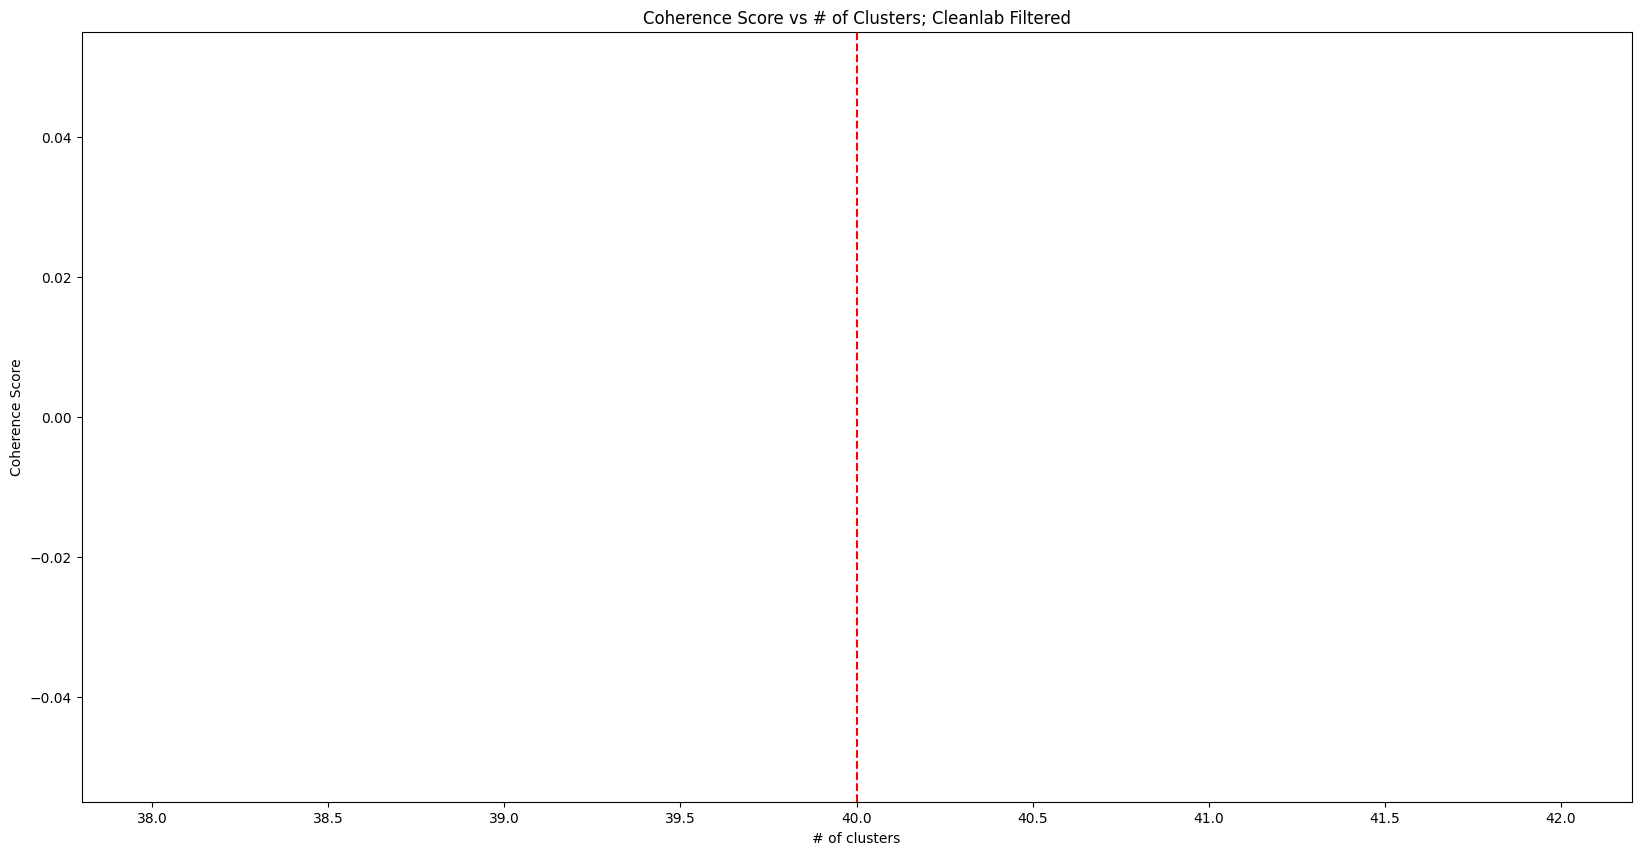

In [ ]:
# Plot Coherence Score averages for Filtered
plt.figure(figsize=(20, 10))
plt.plot(np.arange(0, len(coherence_score_avgs)) , coherence_score_avgs)
plt.title('Coherence Score vs # of Clusters; Cleanlab Filtered')
plt.axvline(x=40, color='red', linestyle='--')
plt.xlabel('# of clusters')
plt.ylabel('Coherence Score')
#plt.xlim(10,49)  # Limits x axis range
# plt.ylim(0,13)  # Limits y axis range
plt.show()

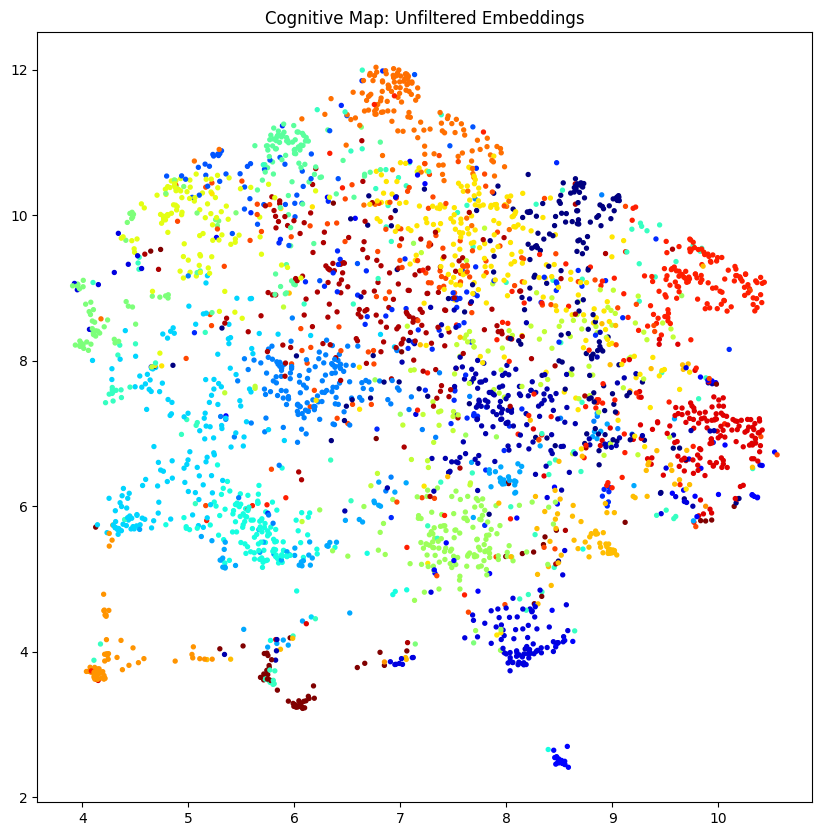

25


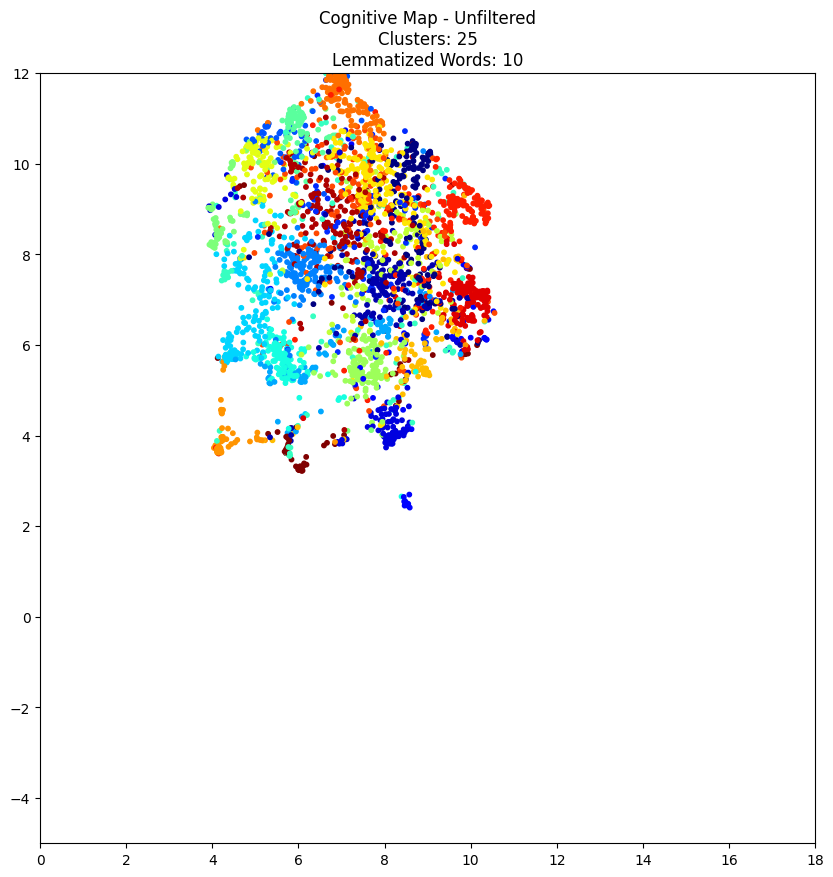

In [ ]:
# UMAP Clustering for Unfiltered Speeches
reducer = umap.UMAP(n_components=2)
unfiltered_sentences_embeddings_reduced = reducer.fit_transform(reduced_unfiltered_embedding)
n_clusters = num_unfiltered_clusters

# Apply KMeans clustering to the unfiltered embeddings
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=kmeans_seed)
kmeans.fit(reduced_unfiltered_embedding)

# Get the cluster labels for each sentence and plot
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(10, 10))
plt.title("Cognitive Map: Unfiltered Embeddings")
plt.scatter(unfiltered_sentences_embeddings_reduced[:, 0], unfiltered_sentences_embeddings_reduced[:, 1], c=labels, cmap='jet', s=8) # s = dot size, cmap variables include cmap = 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# plt.xlim(6,14)  # Limits x axis range
# plt.ylim(0,10)  # Limits y axis range
plt.show()

# print(reduced_embedding.shape)
print(kmeans.n_clusters)
# Concentrated Unfiltered UMAP Plot
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(10, 10))
plt.title("Cognitive Map - Unfiltered" + "\nClusters: {}".format(n_clusters) + "\nLemmatized Words: {}".format(num_lemmatized_words))
plt.scatter(unfiltered_sentences_embeddings_reduced[:, 0], unfiltered_sentences_embeddings_reduced[:, 1], c=labels, cmap='jet', s=10) # s = dot size, cmap variables include cmap = 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.xlim(0,18)  # Limits x axis range
plt.ylim(-5,12)  # Limits y axis range
plt.show()

In [ ]:
# UNFILTERED WORD CLOUD CODE
# Word Cloud
#Original method - probably using this

# Add in when stop words is needed
additional_stopwords = ['thank','may', 'act', 'will', 'good', 'make', 'get', 'need', 'got', 'one', 'day', 'going', 'want', 'many', 'must', 'well', 'thing',
                        'say','new', 'much', 'still', 'first', 'ago', 'bad', 'next', 'yet', 'way', 'saw', 'big', 'know', 'keep', 'use', 'part', 'mean'
                        'tell', 'america', 'american', 'united states', 'us', 'usa', 'long', 'let', 'great', 'said', 'think', 'put', 'nation', 'hard'
                        'man', 'ask', 'people', 'time', 'year', 'back', 'went', 'years', 'came']
stop_words = set(stopwords.words('english'))
stop_words.update(additional_stopwords)
num_sentences_all = []

# List of tokenized sentences
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(unfiltered_sentences)

# Get the words and their tf-idf scores
feature_names = tfidf_vectorizer.get_feature_names_out()
scores = tfidf_matrix.toarray().mean(axis=0)

# Sort the words by their tf-idf scores
sorted_words = sorted(zip(feature_names, scores), key=lambda x: x[1])

lowest_tfidf_words = []
for word, score in sorted_words[:50]:
    lowest_tfidf_words.append(word)
#     print(f"{word}: {score:.4f}")
print(lowest_tfidf_words)

unfiltered_full_cluster_sentences = []
#labels = kmeans.labels_

for i in range(38): # 38 clusters now 
    # Get the indices of sentences belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]
    # print(kmeans.n_clusters, len(cluster_indices), )
    cluster_sentences = [unfiltered_sentences[index] for index in cluster_indices]
    unfiltered_full_cluster_sentences.append(cluster_sentences)
    num_sentences = len(cluster_sentences)
    num_sentences_all.append(num_sentences)
    # Combine the sentences into a single string
    cluster_text = " ".join(cluster_sentences)
    cluster_text =" ".join([ word for word in cluster_text.split() if word.lower() not in lowest_tfidf_words and len(word)>2 and word.lower() not in stop_words])
    
    if coherenceRan_Unfiltered:
      # Generate a word cloud from the cluster text
      wordcloud = WordCloud(max_words=120, width=800, height=800, min_font_size=10, collocations=True, background_color="white").generate(cluster_text)

      # Creates a dictionary of words used in each wordcloud
      # text_dictionary = wordcloud.process_text(cluster_text)
      # word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
      # rel_freq=wordcloud.words_
      # print(list(word_freq.items())[:10])
      # print(list(rel_freq.items())[:10])

      wordcloud.generate(cluster_text)

      # Plot the word cloud
      plt.figure(figsize=(8, 8), facecolor='white')
      # plt.title("Cluster:{}".format(i)) # comment after the coherence scores are ran
      plt.title("Cluster:{}".format(i) + "\nCoherence Score:{}".format(out_unfiltered[i])+ "\n# of Sentences in Cluster:{}".format(num_sentences)) # comment when ran initially
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.tight_layout(pad=0)
      
      file_name = f'{timestamp}_{num_lemmatized_words}_Unfiltered_cluster_{i}_wordcloud.png'
      plt.savefig(folder_path + file_name, dpi=300)
      plt.show()

initialWordcloudRan_Unfiltered = True
num_sentences_all_DF = pd.DataFrame(num_sentences_all)
num_sentences_all_DF.to_csv('num_sentences_all_Unfiltered_DF.csv')

['97herbaceous', '97seem', 'scarcity', 'located', 'readiest', 'cephalopodic', 'inactive', 'worm', '97have', '97vertebr', 'homologise', '23', '85', 'asparagus', 'berries', 'hazel', 'helosciadium', 'nuts', '41421', 'geometer', '93more', '93near', 'concurring', 'credible', 'feline', 'intervention', 'thirds', 'towns', 'villages', 'incalculable', 'aborigines', 'gnathodon', 'intercalated', 'marched', '200', '550', 'dezertas', 'lulls', 'necessitating', 'shines', 'fellow', 'labourers', 'prolong', 'interposition', 'steadiness', 'furious', 'heart', 'ran', 'shortly', 'terrified']


In [34]:
#Unfiltered coherence scores output
word2vec_output_file = '/content/word2vec_1.txt'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

if(initialWordcloudRan_Unfiltered):
  out_unfiltered = calcCoherence(unfiltered_full_cluster_sentences)
  print(out_unfiltered)
  print(sum(out_unfiltered)/len(out_unfiltered))
  out_unfiltered_DF = pd.DataFrame(out_unfiltered)
  file_name = f'{timestamp}_coherence_scores_Unfiltered_{num_lemmatized_words}_n{num_unfiltered_clusters}.csv'
  # out_DF.to_csv(folder_path + file_name)
  coherenceRan_Unfiltered = True


[('queen', 0.6713277101516724)]


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


[-0.0745682530096166, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297, 0.04678568838295297]
0.043592163609464274


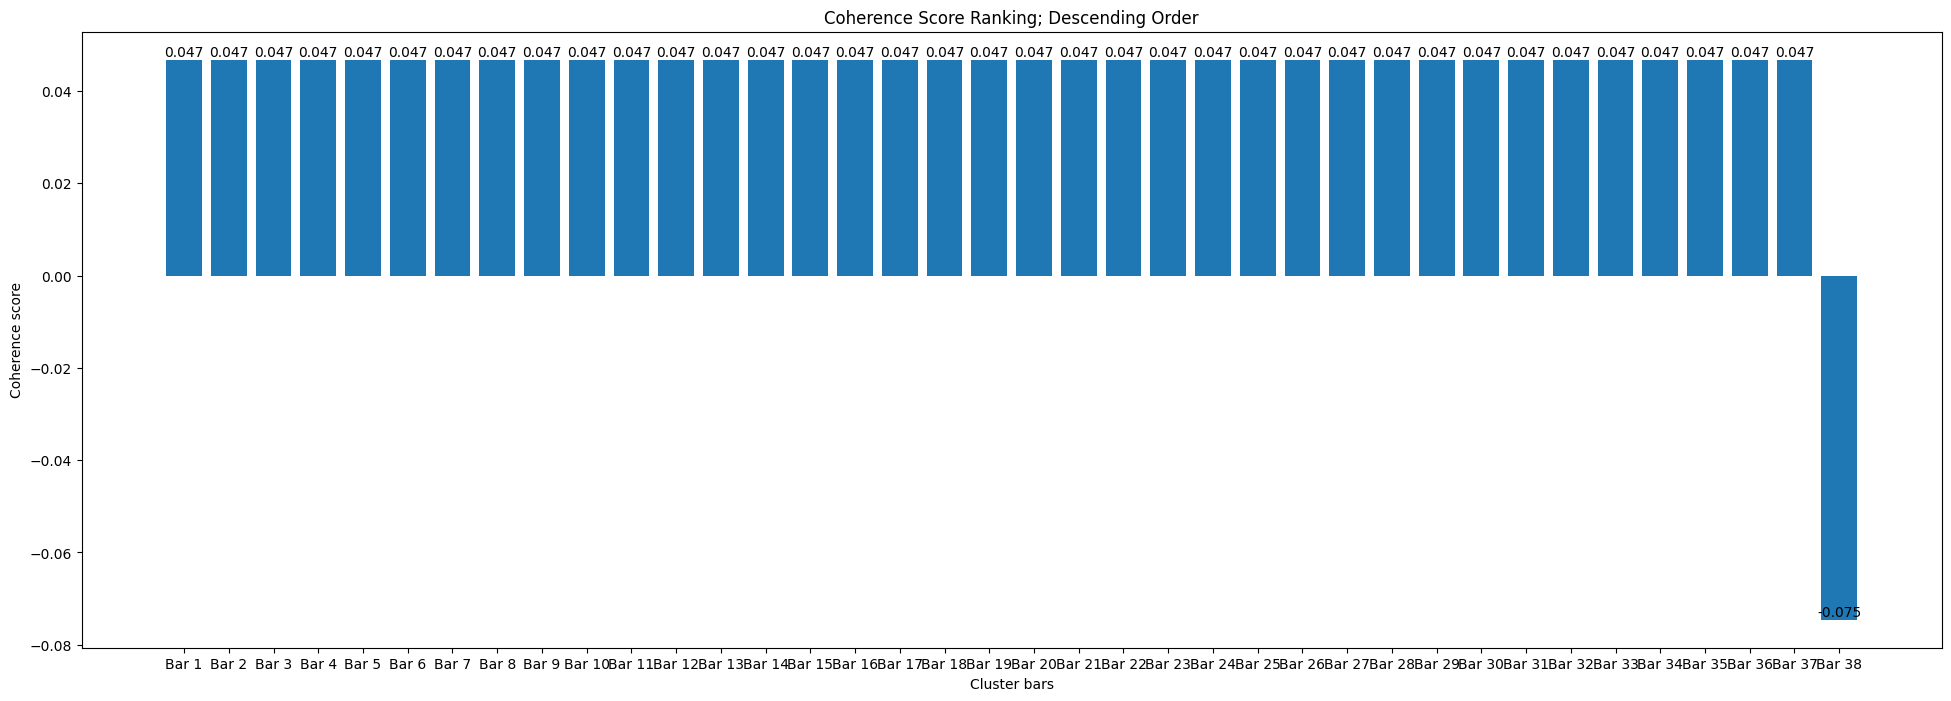

In [35]:
#Plot descending coherence score values
# Unfiltered
fig = plt.figure(figsize=(24, 8))
sorted_values = sorted(out_unfiltered, reverse=True)
labels_bar = ['Bar {}'.format(i+1) for i in range(len(out_unfiltered))]
plt.bar(labels_bar, sorted_values)
for i, out_unfiltered in enumerate(sorted_values):
    plt.text(i, out_unfiltered, round(out_unfiltered,3), ha='center', va='bottom')
plt.xlabel('Cluster bars')
plt.ylabel('Coherence score')
plt.title('Coherence Score Ranking; Descending Order')
plt.show()

In [36]:
#  coherence score graph (changes n_clusters)
#unFiltered
coherence_score_avgs_unfiltered = []
for x in range(1,50):
  kmeans = KMeans(n_clusters = x, n_init=10, random_state=kmeans_seed)
  kmeans.fit(reduced_unfiltered_embedding)
  full_cluster_sentences_unfiltered_temp = []
  labels = kmeans.labels_
  for i in range(kmeans.n_clusters): # 10 clusters now
      # Get the indices of sentences belonging to the current cluster
      cluster_indices = np.where(labels == i)[0]
      cluster_sentences = [unfiltered_sentences[index] for index in cluster_indices]
      full_cluster_sentences_unfiltered_temp.append(cluster_sentences)
  coherence_Scores = calcCoherence(full_cluster_sentences_unfiltered_temp)
  coherence_Scores_Average = float(np.mean(coherence_Scores))
  coherence_score_avgs_unfiltered.append(coherence_Scores_Average)
  print(x, "Clusters:", coherence_Scores_Average)

coherence_score_avgs_unfiltered.insert(0,0) # add a 0 to the beginning of the list so the index correlates to the number of clusters
print(coherence_score_avgs_unfiltered)

#Save coherence score to CSV
coherence_score_avgs_DF = pd.DataFrame(coherence_score_avgs_unfiltered)
coherence_score_avgs_DF.to_csv('coherence_score_avgs_unfiltered.csv')

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


1 Clusters: -0.0012502806328129703


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


2 Clusters: 0.13789707014235578


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


3 Clusters: 0.1102149655038815


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


4 Clusters: 0.10288609193443912


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


5 Clusters: 0.11190829297623599


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


6 Clusters: 0.09826040359281242


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


7 Clusters: 0.1124854850185776


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


8 Clusters: 0.10423566313572614


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


9 Clusters: 0.09751307135593353


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


10 Clusters: 0.10450309772755037


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


11 Clusters: 0.08651639862891415


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


12 Clusters: 0.10726867264325167


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


13 Clusters: 0.10903637599764796


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


14 Clusters: 0.10320316983196941


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


15 Clusters: 0.10031055486075763


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


16 Clusters: 0.08941348456171408


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


17 Clusters: 0.09774950271808736


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


18 Clusters: 0.09627485952973411


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


19 Clusters: 0.09618088867757904


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


20 Clusters: 0.1087672871113087


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


21 Clusters: 0.09560654996834007


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


22 Clusters: 0.08253557601603924


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


23 Clusters: 0.10134590434648712


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


24 Clusters: 0.09303859845349573


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


25 Clusters: 0.08469240916384413


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


26 Clusters: 0.10053530670020173


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


27 Clusters: 0.10167968123607789


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


28 Clusters: 0.10244921198830681


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


29 Clusters: 0.08732637564969595


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


30 Clusters: 0.09341733719376652


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


31 Clusters: 0.09372740762919284


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


32 Clusters: 0.09173174004079858


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


33 Clusters: 0.09329544819611527


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


34 Clusters: 0.09177909197584602


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


35 Clusters: 0.0909558829388665


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


36 Clusters: 0.09317071275673991


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


37 Clusters: 0.09779503712172564


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


38 Clusters: 0.09913434912065588


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


39 Clusters: 0.09449643917298005


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


40 Clusters: 0.0966875857798896


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


41 Clusters: 0.08841356258752099


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


42 Clusters: 0.08712007944896827


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


43 Clusters: 0.09030052962822938


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


44 Clusters: 0.09773990335665159


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


45 Clusters: 0.08393828426939742


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


46 Clusters: 0.0879929434876048


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


47 Clusters: 0.09233020879921056


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


48 Clusters: 0.08681104653753101


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


49 Clusters: 0.09205063890447172
[0, -0.0012502806328129703, 0.13789707014235578, 0.1102149655038815, 0.10288609193443912, 0.11190829297623599, 0.09826040359281242, 0.1124854850185776, 0.10423566313572614, 0.09751307135593353, 0.10450309772755037, 0.08651639862891415, 0.10726867264325167, 0.10903637599764796, 0.10320316983196941, 0.10031055486075763, 0.08941348456171408, 0.09774950271808736, 0.09627485952973411, 0.09618088867757904, 0.1087672871113087, 0.09560654996834007, 0.08253557601603924, 0.10134590434648712, 0.09303859845349573, 0.08469240916384413, 0.10053530670020173, 0.10167968123607789, 0.10244921198830681, 0.08732637564969595, 0.09341733719376652, 0.09372740762919284, 0.09173174004079858, 0.09329544819611527, 0.09177909197584602, 0.0909558829388665, 0.09317071275673991, 0.09779503712172564, 0.09913434912065588, 0.09449643917298005, 0.0966875857798896, 0.08841356258752099, 0.08712007944896827, 0.09030052962822938, 0.09773990335665159, 0.08393828426939742, 0.0879929434876048, 

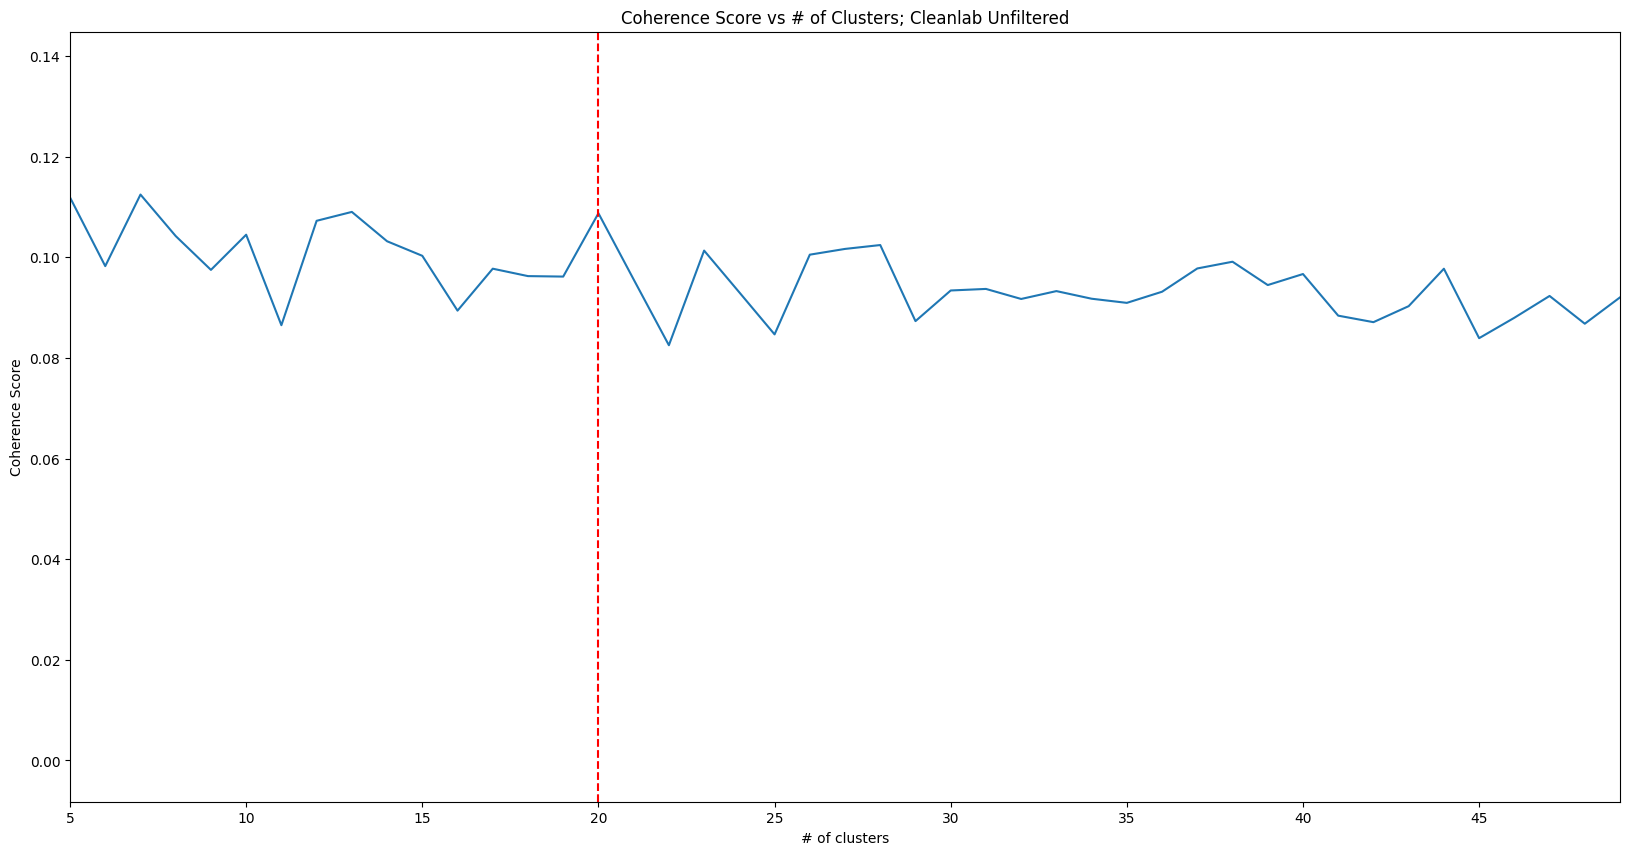

In [38]:
# Plot Coherence Score averages for Unfiltered
plt.figure(figsize=(20, 10))
plt.plot(np.arange(0, len(coherence_score_avgs_unfiltered)) , coherence_score_avgs_unfiltered)
plt.title('Coherence Score vs # of Clusters; Cleanlab Unfiltered')
plt.axvline(x=20, color='red', linestyle='--')
plt.xlabel('# of clusters')
plt.ylabel('Coherence Score')
plt.xlim(5,49)  # Limits x axis range
# plt.ylim(0,13)  # Limits y axis range
plt.show()

In [ ]:
# --------------------------Code Below Is Trials and NOT Implemented----------------------------------------------------------------------------

In [39]:
# LDA 
# filtered_speech_embeddings = model.encode(post_cleanlab_sentences) # embedding
# unfiltered_speech_embeddings = model.encode(unfiltered_sentences)
additional_stopwords = ['may', 'act', 'will', 'good', 'make', 'get', 'need', 'got', 'one', 'day', 'going', 'want', 'many', 'must', 'well', 'thing',
                        'say','new', 'much', 'still', 'first', 'ago', 'bad', 'next', 'yet', 'way', 'saw', 'big', 'know', 'keep', 'use', 'part', 'mean'
                        'tell', 'america', 'american', 'united states', 'us', 'usa', 'long', 'let', 'great', 'said', 'think', 'put', 'nation', 'hard'
                        'man', 'ask', 'people', 'time', 'year', 'back', 'went', 'years', 'came', 'united  states', '(', ':', ')', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ',', '/', '\\' + string.ascii_letters]
stop_words = set(stopwords.words('english'))
stop_words.update(additional_stopwords)

documents = speeches
documents = [' '.join([word for word in string.split() if word.lower() not in stop_words]) for string in documents]

# print(documents[0])
tokenized_docs = [doc.lower().split() for doc in documents]

# print(tokenized_docs)
# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_docs)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]


# Train the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary, 
                                            num_topics=35, 
                                            random_state=42,
                                            passes=10)
#pprint(lda_model.print_topics())

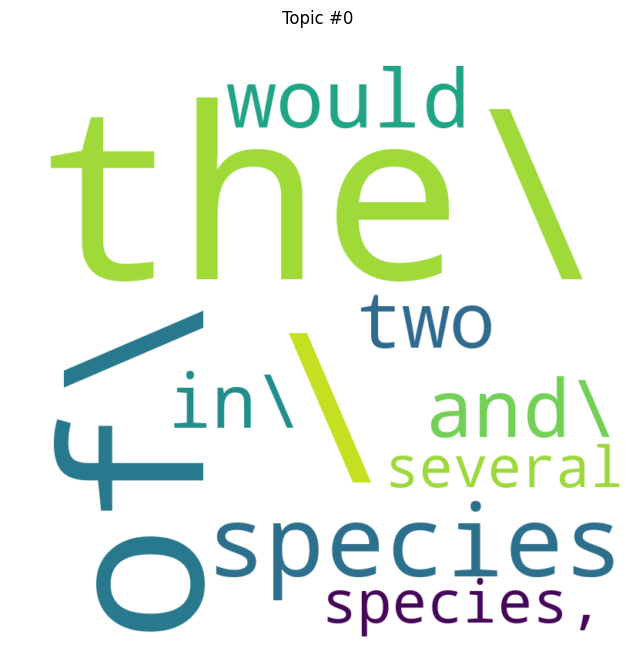

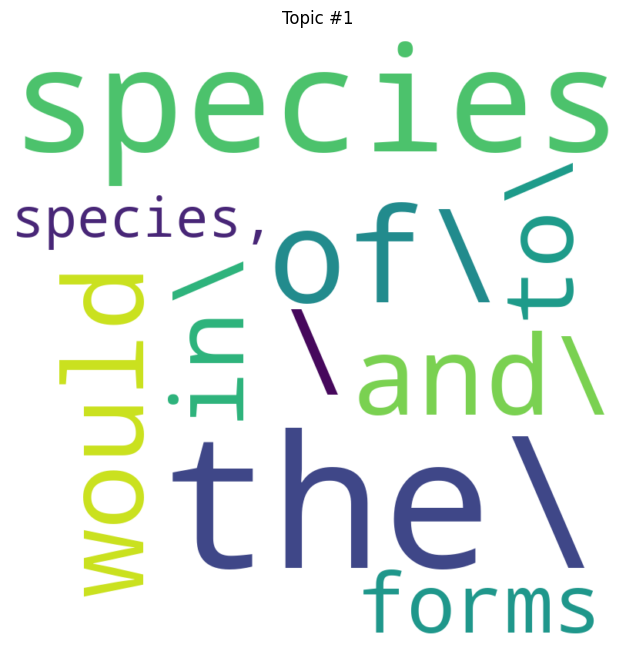

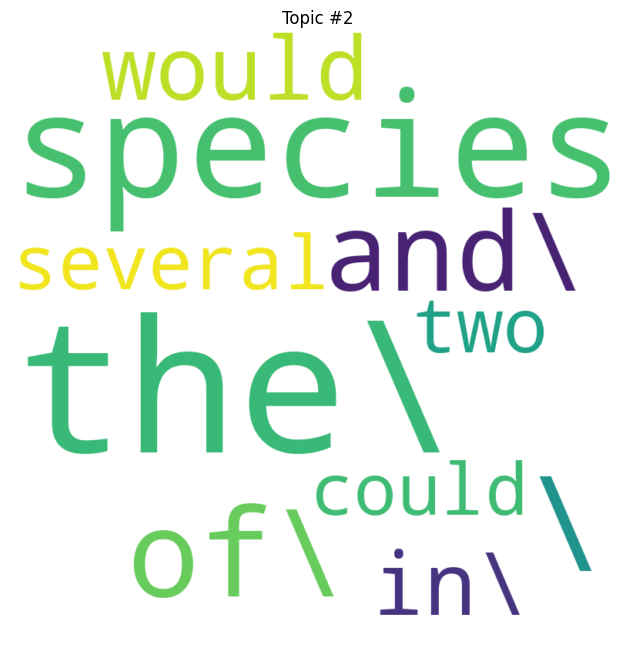

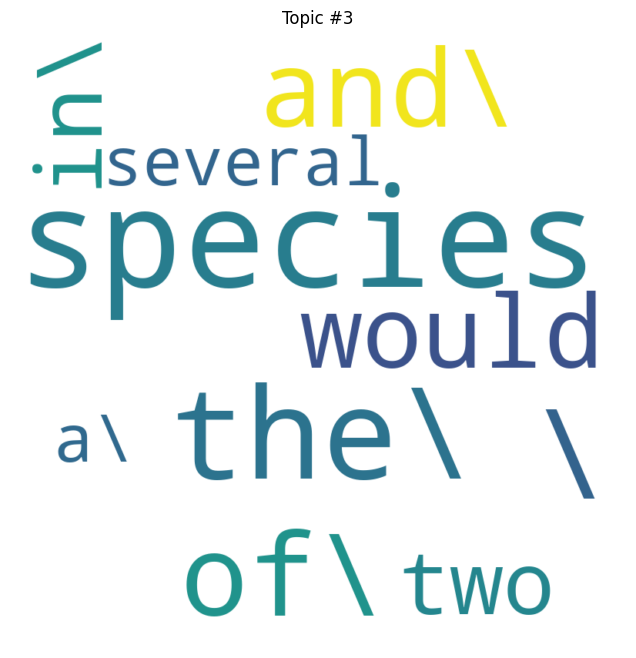

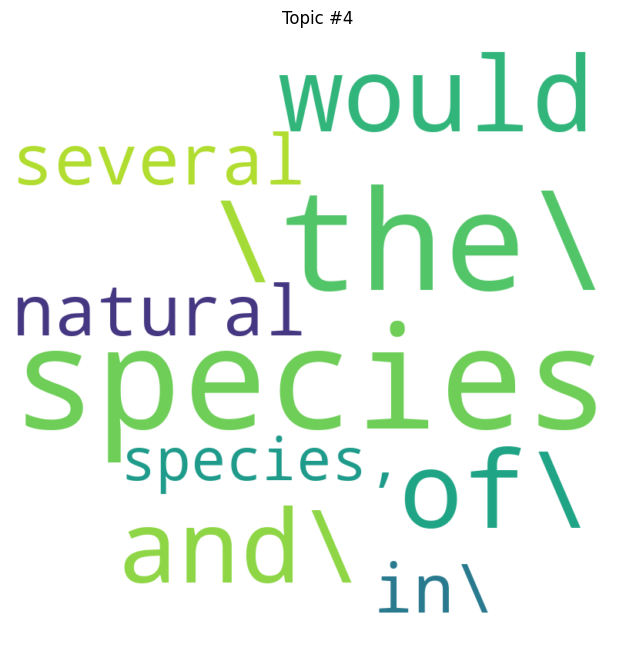

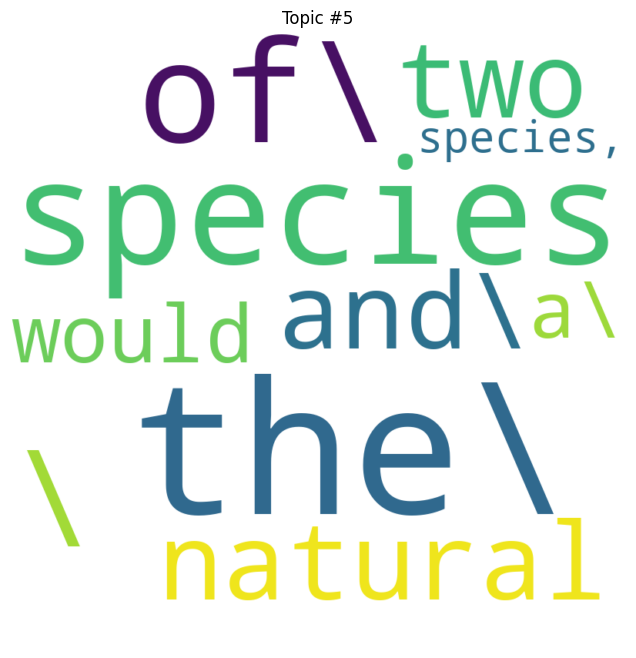

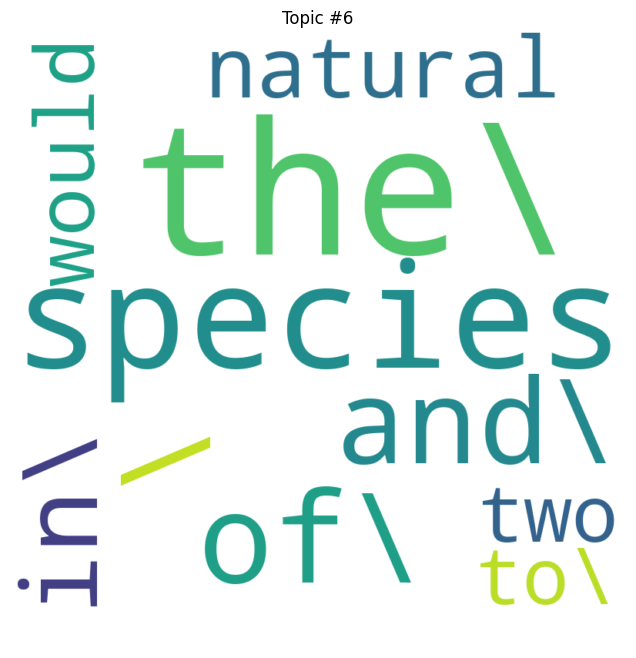

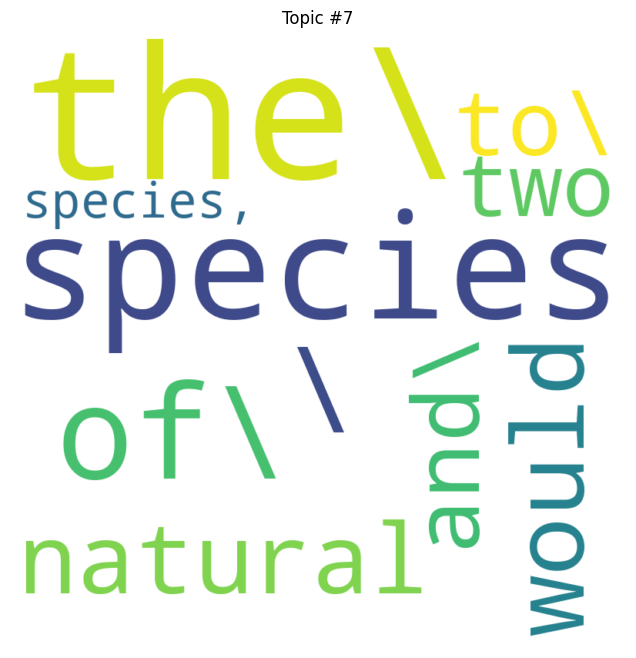

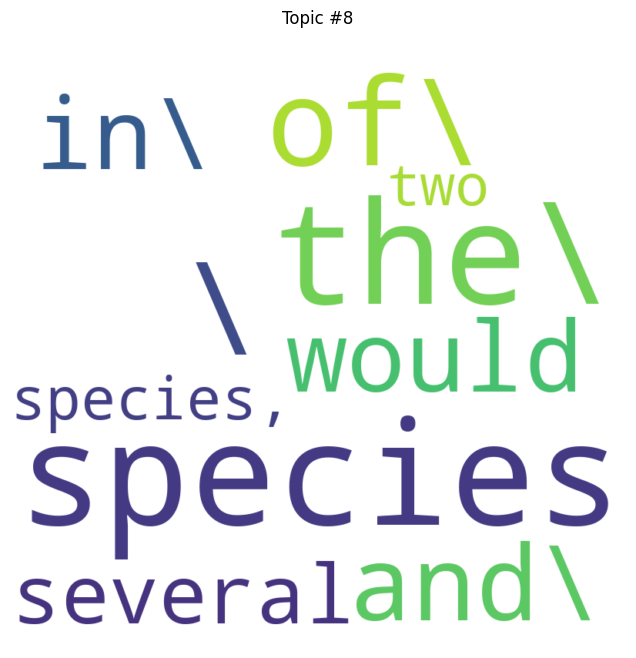

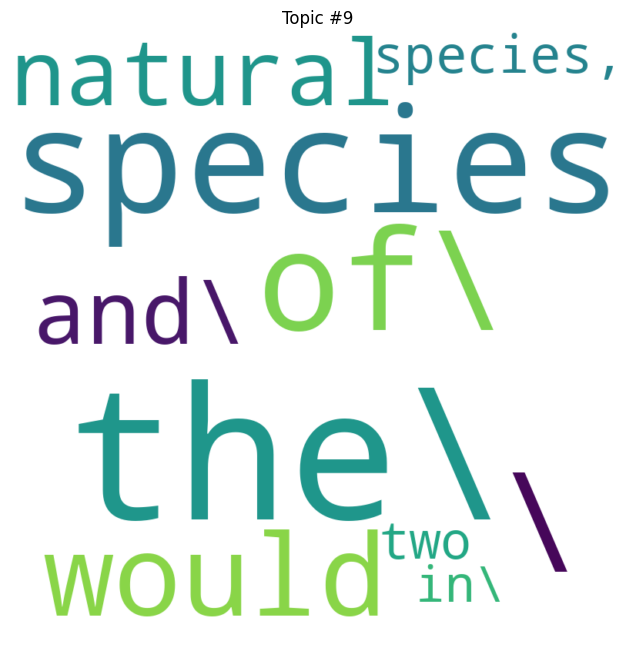

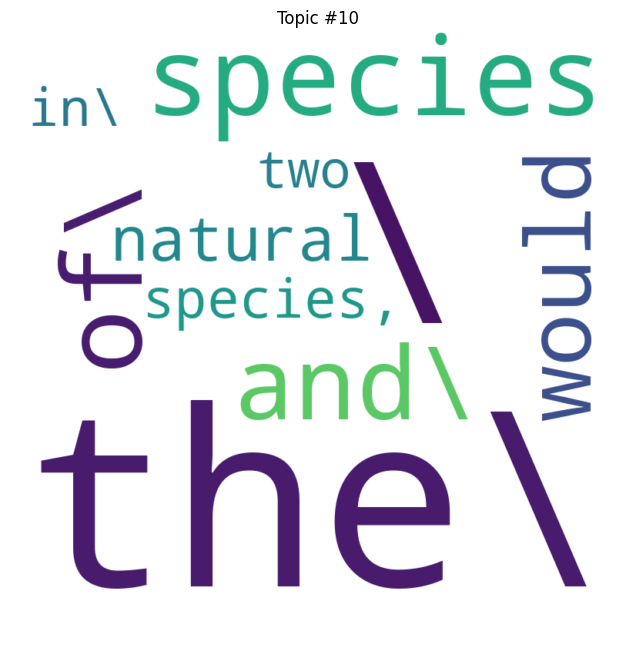

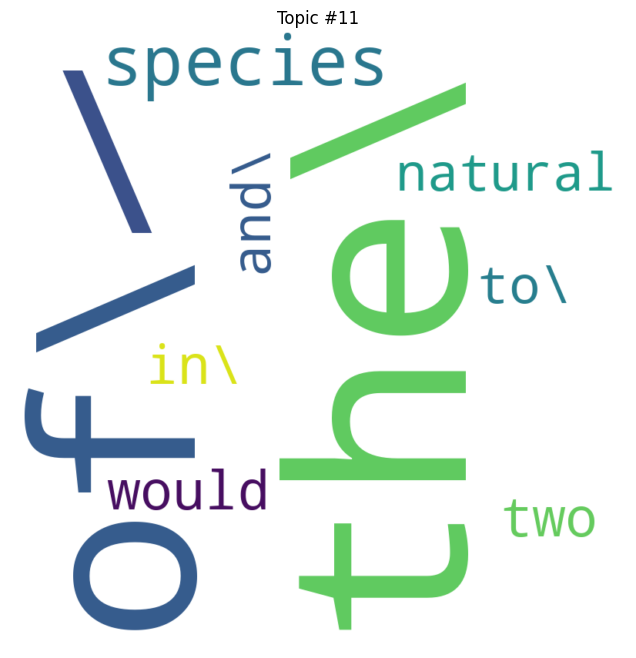

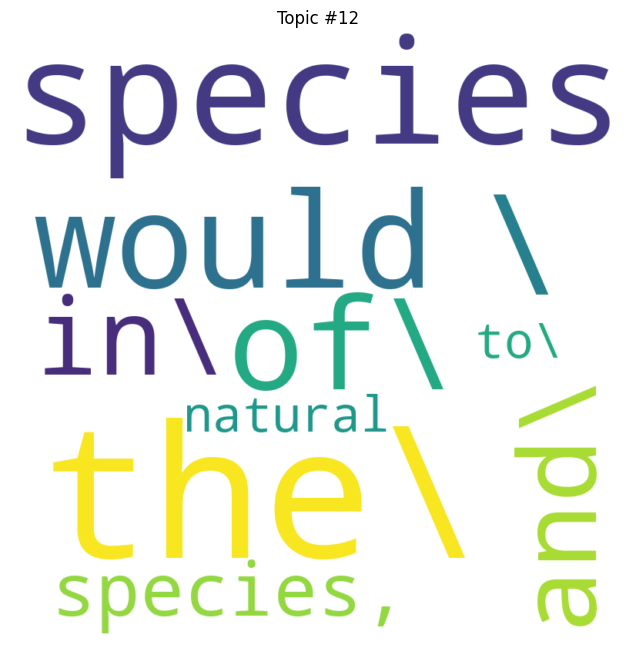

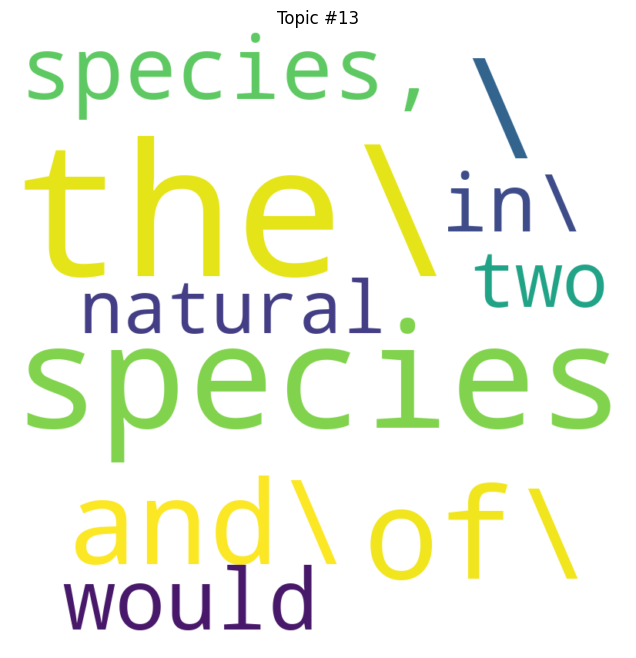

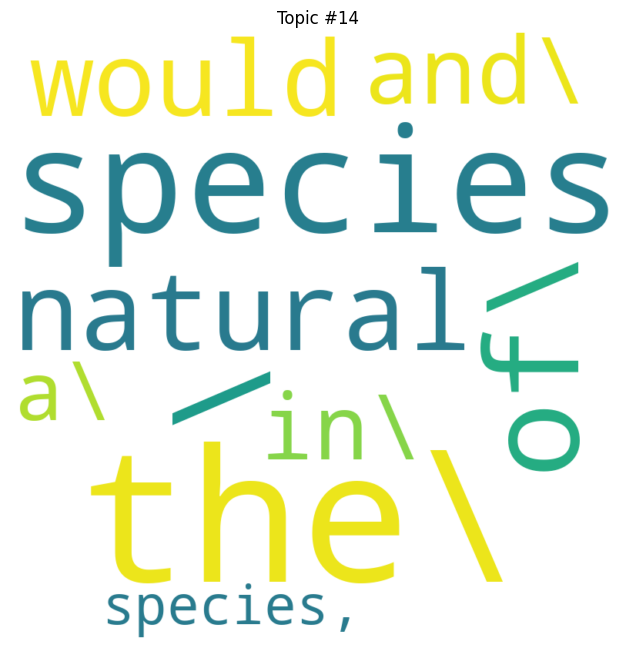

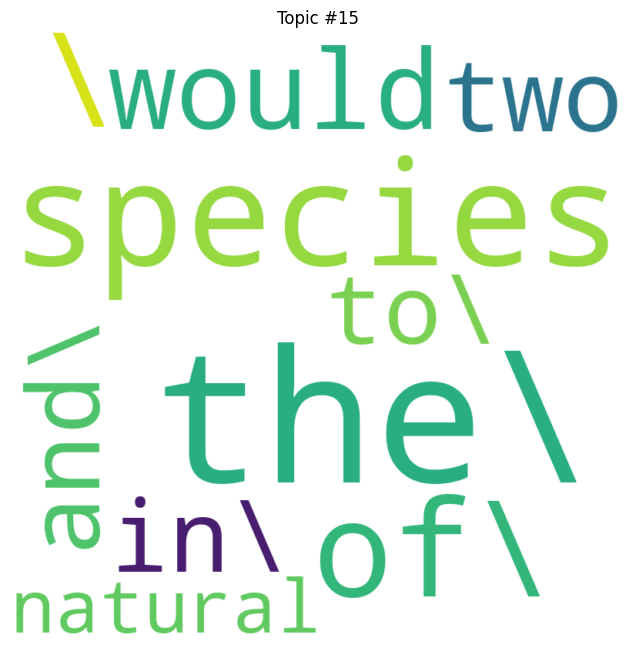

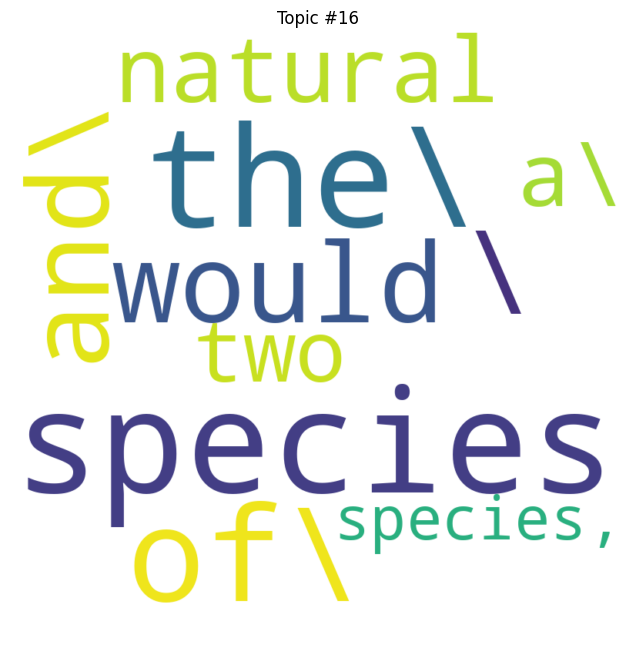

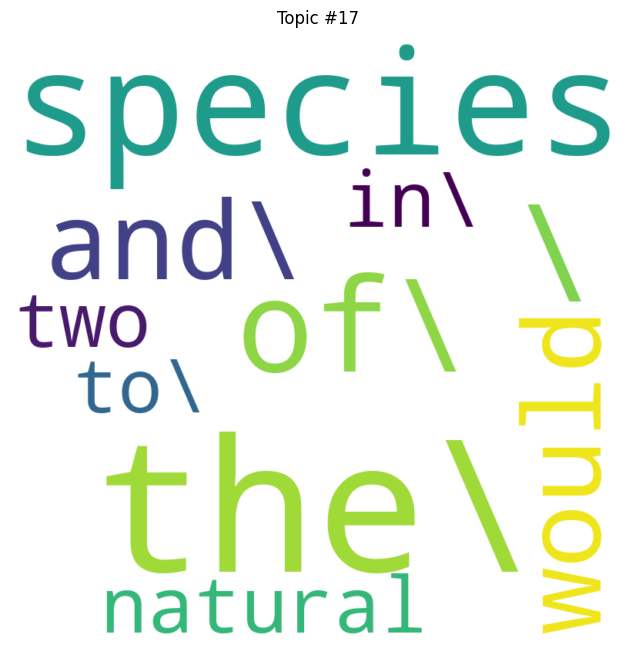

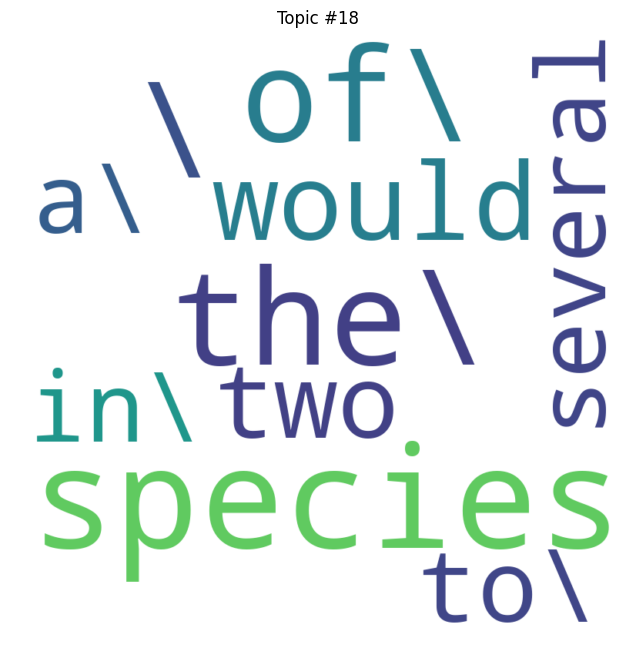

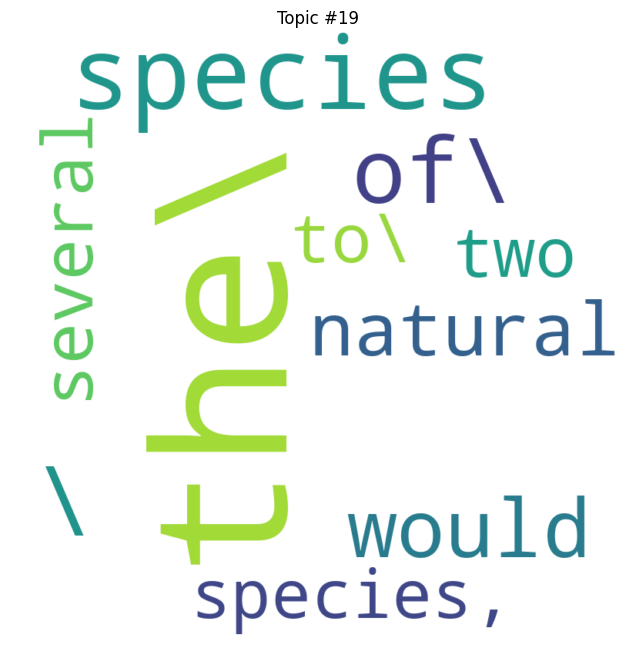

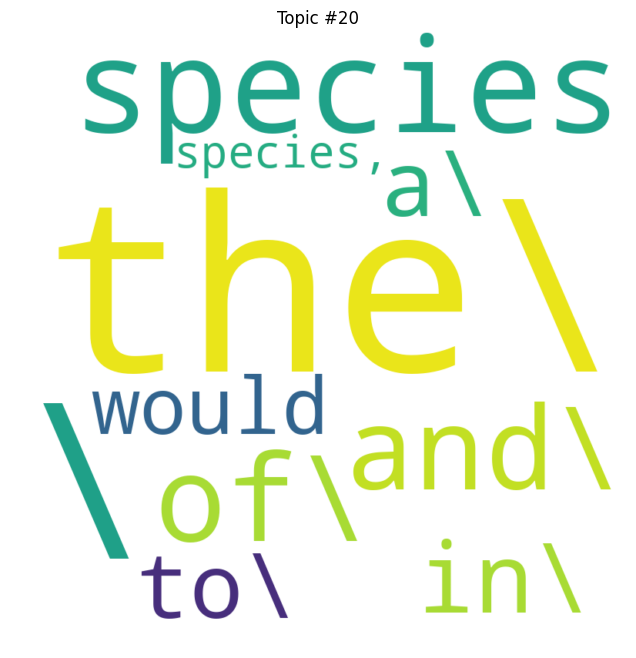

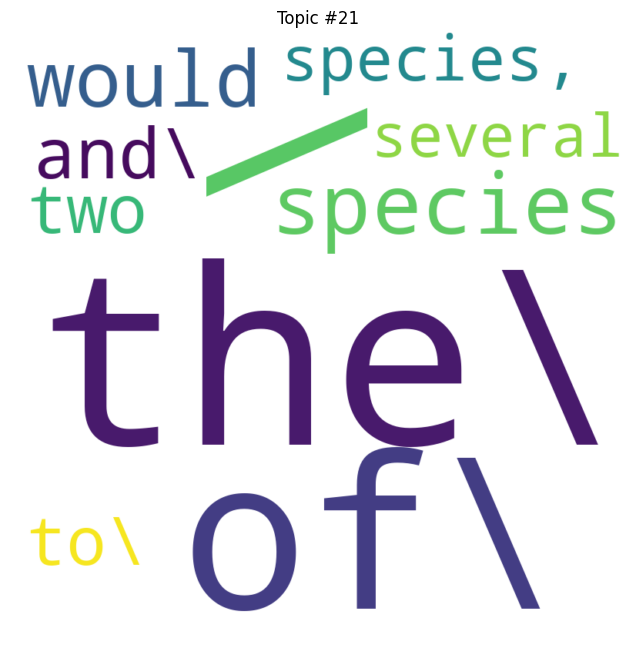

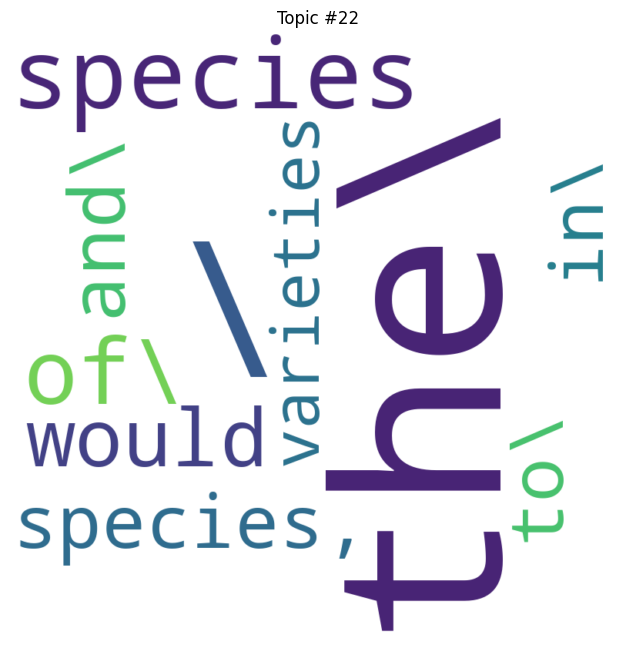

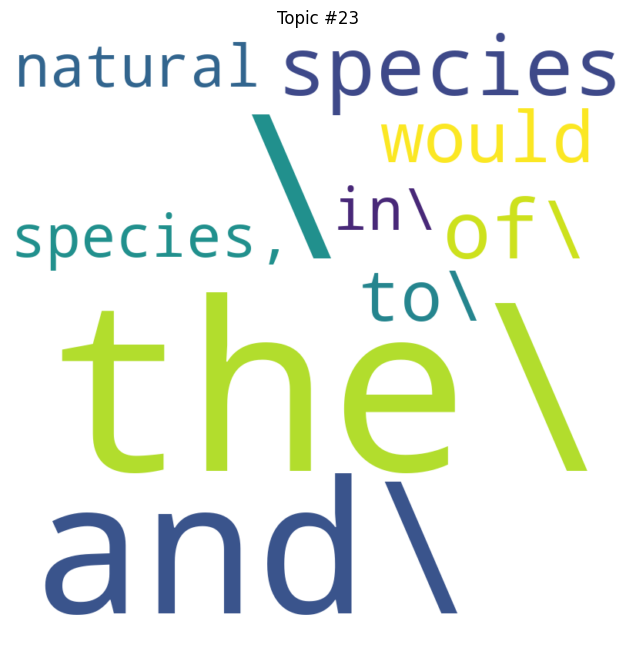

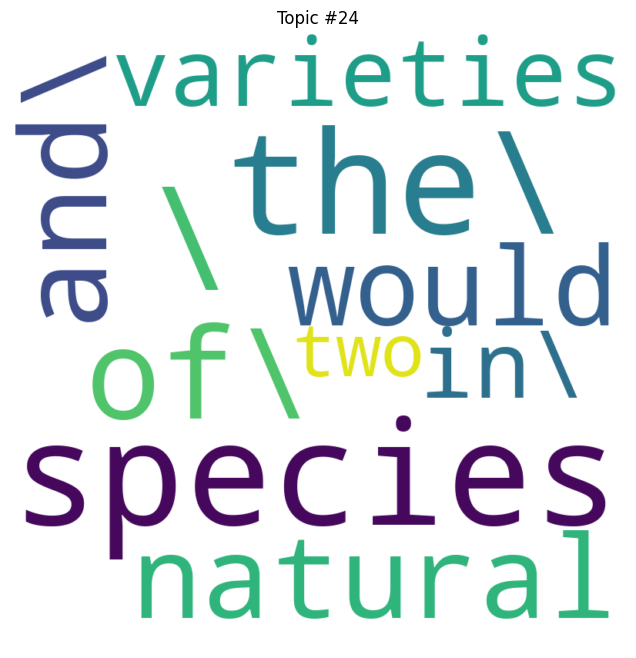

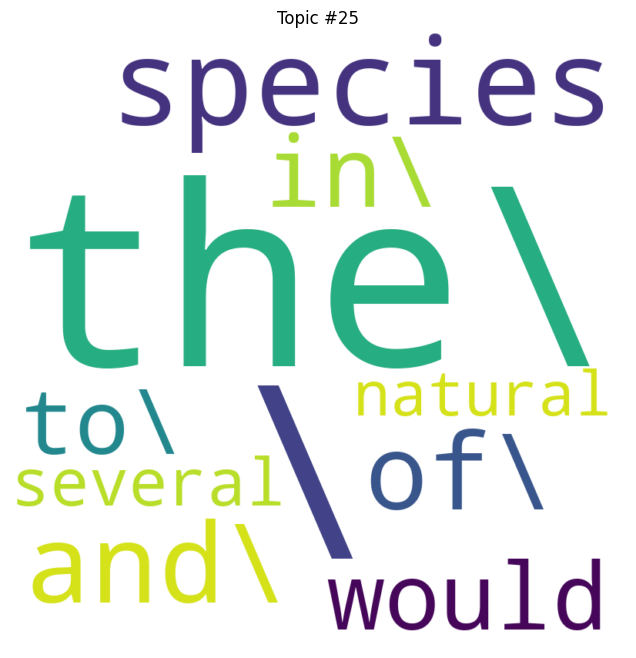

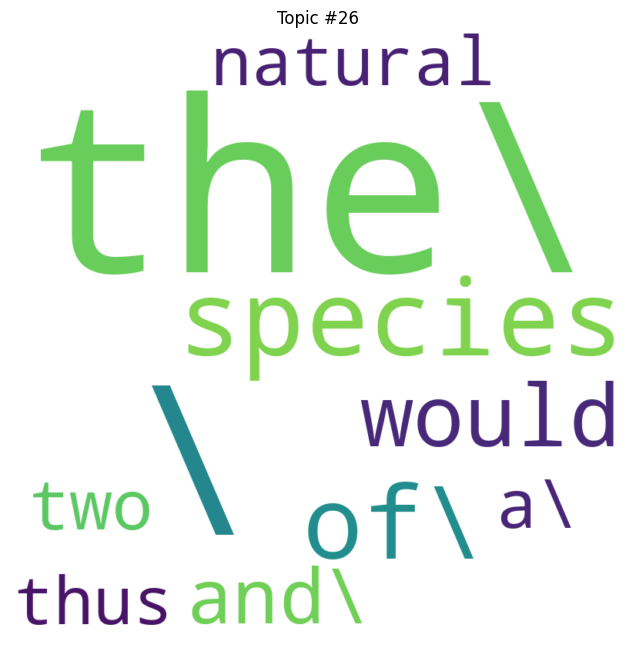

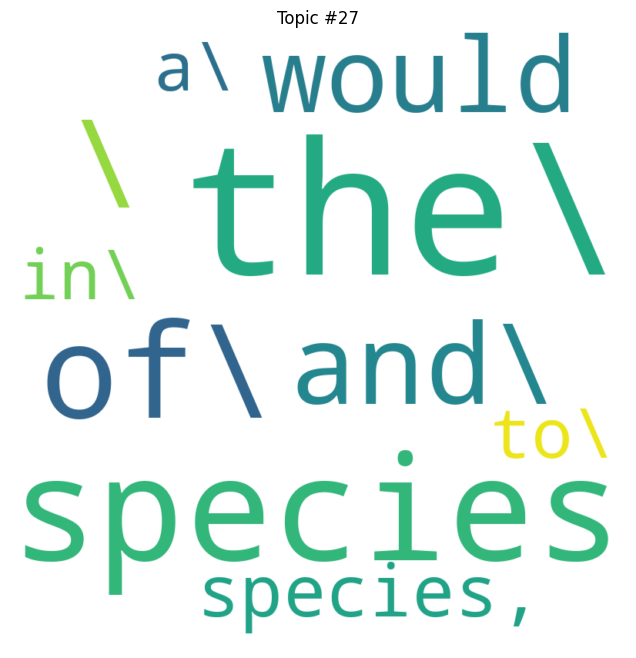

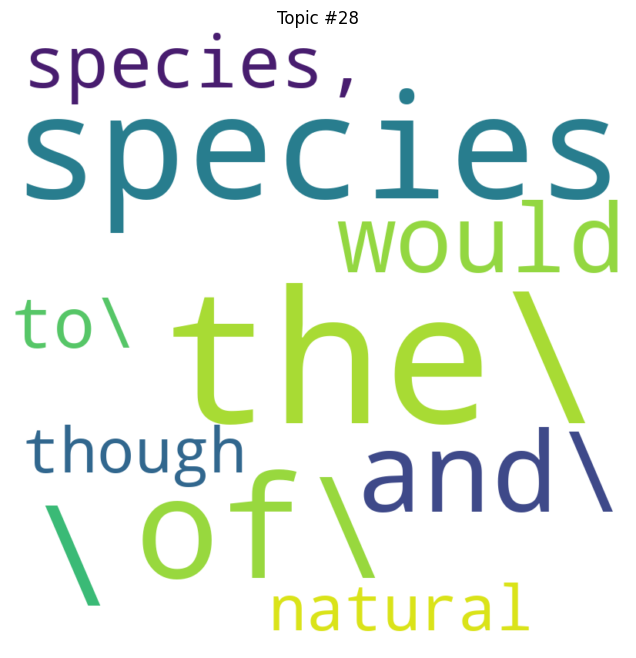

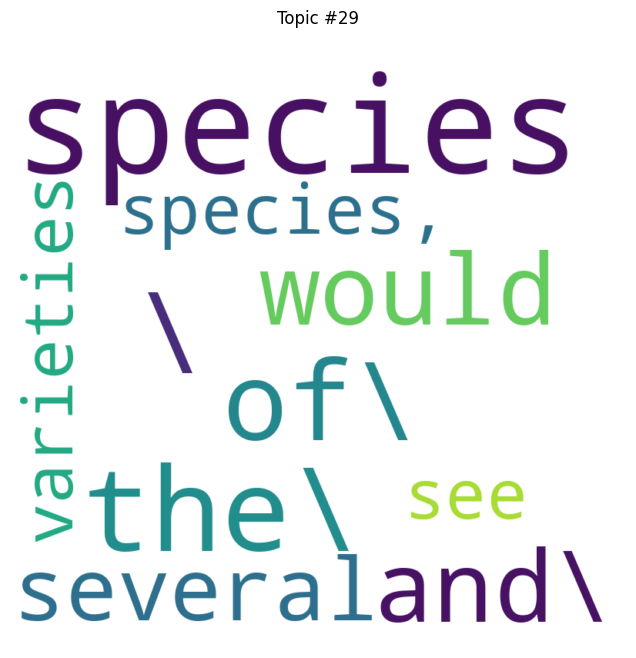

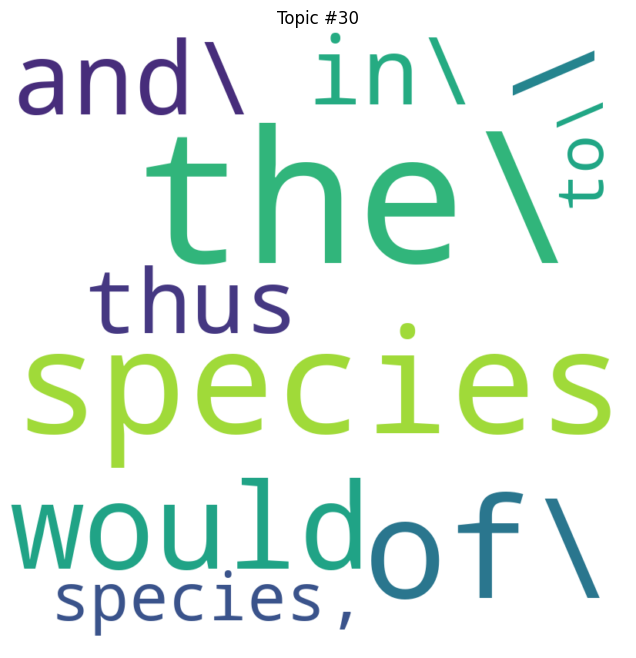

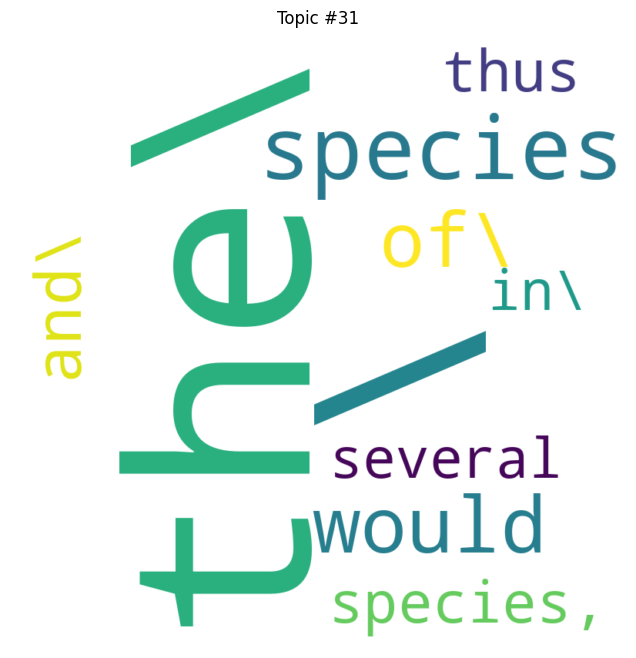

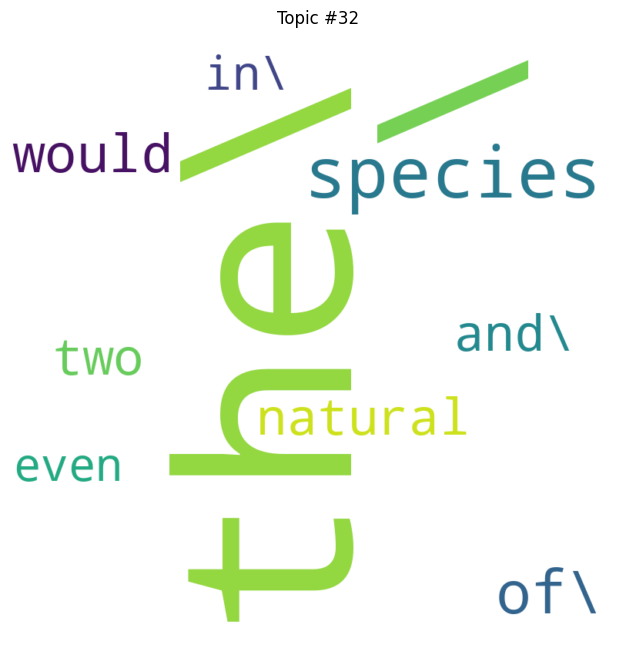

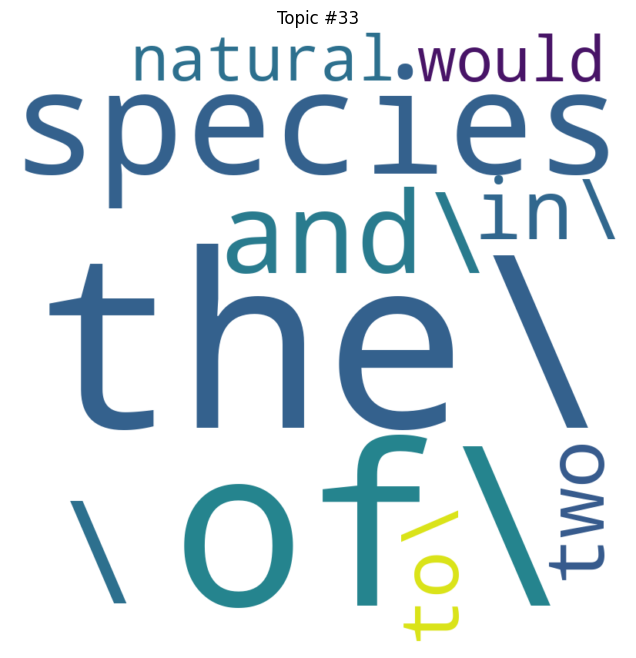

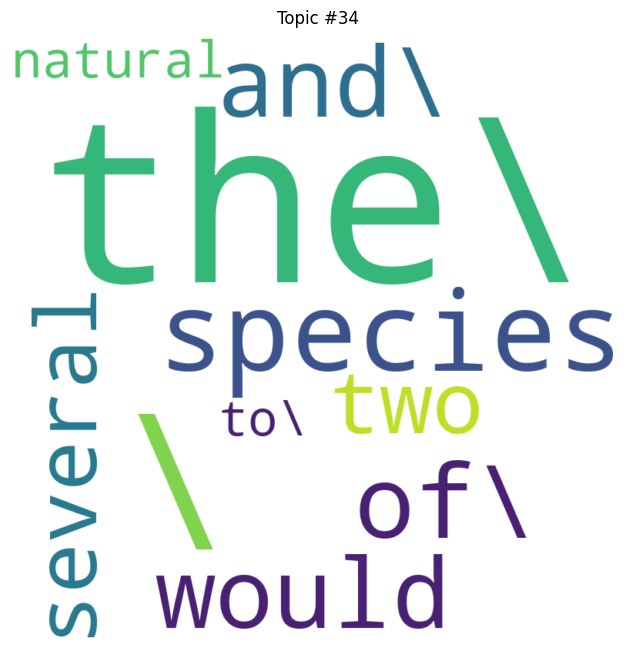

In [40]:
# Generate word clouds for each topic
for topic_id in range(lda_model.num_topics):
    # Get the most significant words for the topic
    topic_words = lda_model.show_topic(topic_id, topn=10)
    # Create a dictionary of the topic words and their weights
    word_weights = {word: weight for word, weight in topic_words}
    # Generate a word cloud for the topic
    wc = WordCloud(background_color="white", 
                   width=800, 
                   height=800, 
                   max_words=120, 
                   min_font_size=10,).generate_from_frequencies(word_weights)
    # Plot the word cloud
    plt.figure(figsize=(8, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic #{topic_id}")
    plt.show()


In [41]:
from sklearn.neighbors import NearestNeighbors


####### FUNCTIONS (main code at end) ###################
# # find nearest neighbors given embeddings
def nn(x):
  nbrs = NearestNeighbors(n_neighbors=numNeighbors).fit(x)
  distances, indices = nbrs.kneighbors()
  return distances, indices

# Get neighborhood score of clusters

def categoryScores(labels, catNeighbors): # load labels and list of neighbors

  catScores = []
  
  for descLabelIdx in range(len(set(labels))): # loop through set of cluster numbers
    
    classCount = labels.count(descLabelIdx) #count number of desc that have current label

    q = 0
    for i in range(len(labels)): # loop through labels of each description
      f = 0
      if labels[i]==descLabelIdx:        
        catNeighbor = catNeighbors[i]          
        for n in catNeighbor:
          curNeighborsLabel = labels[n]
          if curNeighborsLabel == descLabelIdx:
            f = f + 1 # increment count of number of neighbors that are of the same cluster
        # use formula to get score
        f = f / len(catNeighbors[i])
        p = classCount / len(labels)
        q = q + (f-p) / (f*(1-p)+(1-f)*p)
    Q = q / classCount
    #catScores.append([descLabelIdx, Q]) # output list will have lists of size 2 with cluster number and score
    catScores.append(Q)

  return catScores


############## MAIN CODE #####################

 # User inputs

labels = kmeans.labels_
# labels is a 1-D list of corresponding to the cluster every sentence belongs to
  # ex. [1, 4, 325, 32, ...]

descEmbeddings = reduced_embedding
# descEmbeddings is a list of all the embeddings corresponding to each sentence. Same as in the other code.
  # ex. [
  #         [234432, 42342, 423424, 423, ..............................],
  #         [234432, 42342, 423424, 423, ..............................],
  #         [234432, 42342, 423424, 423, ..............................],
  #          .
  #          .
  #          .
  #     ]

numNeighbors = 3 + 1 # Number of neighbors. Leave as is for 3 nearest neighbors. (Will be 1 more than n).
neighbor_distances, neighbor_indices = nn(descEmbeddings) # Get neigbhor_indices which is a 2-D list of nearest neighbors for each point.
neighbors = neighbor_indices.tolist() # Get neibhbors from indices

catScores = categoryScores(labels.tolist(), neighbors) # Get final scores
print(catScores)


IndexError: ignored

In [ ]:
df = pd.DataFrame(catScores)
df.to_csv('catScoresFiltered6.csv')

In [ ]:
#remove common sentences (sentences with alot of bad words)
unique_unfiltered_sentences = list(set(unfiltered_sentences))
print(len(unfiltered_sentences), len(unique_unfiltered_sentences))

In [ ]:
#NEW FILTER
#CHECK HERE IF WORKS
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors


word2vec_output_file = '/content/word2vec.txt'
# load GloVe model
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
# define dataset
dataset = unique_unfiltered_sentences
#dataset = ['This is a sample sentence.', 'The quick brown fox jumps over the lazy dog.', 'This is another sample sentence.', 'The quick brown fox jumps over the lazy dog again.']

# define function to calculate GloVe score for a sentence
def calculate_glove_score(sentence):
    # tokenize sentence into words
    words = word_tokenize(sentence)
    # calculate mean GloVe vector for words in sentence
    glove_vector = np.mean([glove_model[word] for word in words if word in glove_model.vocab], axis=0)
    # calculate rank of GloVe vector among all vectors in model
    rank = len([x for x in glove_model.similar_by_vector(glove_vector, topn=len(glove_model.vocab)) if x[0] in words])
    # divide rank by number of words in sentence
    score = rank / len(words)
    return score

# calculate GloVe scores for all sentences in dataset
scores = [calculate_glove_score(sentence) for sentence in dataset]
#cuttoff for removing sentences? look at distribution, invert to z scores and standardize it, then look at stdev and find point where it makes sense
# print scores
#print(scores)
z_scores = (scores - np.mean(scores)) / np.std(scores)
std_dev = np.std(z_scores)
cutoff = np.mean(scores) - 2 * std_dev
glove_filtered_sentences = [sentence for i, sentence in enumerate(dataset) if scores[i] > cutoff]
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')
glove_filtered_sentence_embeddings = model.encode(glove_filtered_sentences)



In [ ]:
# PCA-95 Dimensionality Reduction
pca = PCA(n_components=0.95)
glove_reduced_embedding = pca.fit_transform([f for f in glove_filtered_sentence_embeddings])  # glove filtered sentence embedding is using post_cleanlab_sentences variable
print(glove_reduced_embedding.shape)

In [ ]:
# Filtered UMAP Clustering
reducer = umap.UMAP(n_components=2)
sentences_embeddings_reduced = reducer.fit_transform(glove_reduced_embedding)

# Apply KMeans clustering to the reduced embeddings
n_clusters = 38


kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=kmeans_seed)
kmeans.fit(glove_reduced_embedding)

# Get the cluster labels for each sentence and plot
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(12, 6))
plt.title("Cognitive Map: Cleanlab Filtered")
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels, cmap='jet', s=8) # s = dot size, cmap variables include cmap = 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# plt.xlim(6,14)  # Limits x axis range
# plt.ylim(0,10)  # Limits y axis range

kmeans_labels_sorted_data = [[] for i in range(n_clusters)]
embeddings_by_cluster = [[] for i in range(n_clusters)]
for i, label in enumerate(labels):
  kmeans_labels_sorted_data[label].append(i)
  embeddings_by_cluster.append(glove_reduced_embedding[i])

plt.show()

# Does the two dimensions just represent the visual cluster comparison? KMeans is nonlinear

print(glove_reduced_embedding.shape)
print(kmeans.n_clusters)
# Concentrated UMAP Plot
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(20, 5))
plt.title("Cluster Map: Cleanlab Filtered Reduced Embeddings")
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels, cmap='jet', s=10) # s = dot size, cmap variables include cmap = 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.xlim(3,15)  # Limits x axis range
plt.ylim(0,16)  # Limits y axis range
plt.show()

In [ ]:
# ADD WORD CLOUD CODE
#Filtered
# Word Cloud
#Original method - probably using this

# Add in when stop words is needed
additional_stopwords = ['may', 'act', 'will', 'good', 'make', 'want', 'get', 'need', 'got', 'one', 'will', 'day', 'going', 'want', 'many']
stop_words = set(stopwords.words('english'))
stop_words.update(additional_stopwords)

# List of tokenized sentences
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(glove_filtered_sentences)

# Get the words and their tf-idf scores
feature_names = tfidf_vectorizer.get_feature_names_out()
scores = tfidf_matrix.toarray().mean(axis=0)

# Sort the words by their tf-idf scores
sorted_words = sorted(zip(feature_names, scores), key=lambda x: x[1])

lowest_tfidf_words = []
for word, score in sorted_words[:50]:
    lowest_tfidf_words.append(word)
#     print(f"{word}: {score:.4f}")
print(lowest_tfidf_words)

full_cluster_sentences = []
#labels = kmeans.labels_
nclusters = 38
for i in range(kmeans.n_clusters): # 38 clusters now 
    # Get the indices of sentences belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]
    cluster_sentences = [glove_filtered_sentences[index] for index in cluster_indices]
    full_cluster_sentences.append(cluster_sentences)

    # Combine the sentences into a single string
    cluster_text = " ".join(cluster_sentences)
    cluster_text =" ".join([ word for word in cluster_text.split() if word.lower() not in lowest_tfidf_words and len(word)>2 and word.lower() not in stop_words])
    # Generate a word cloud from the cluster text


    # wordcloud = WordCloud(min_font_size=4, 
    #                       mask=mask,
    #                       width=mask.shape[1],
    #                       height=mask.shape[0],
    #                       stopwords=lowest_tfidf_words, 
    #                       background_color="white",
    #                       contour_width=1,
    #                       contour_color="black")
    wordcloud = WordCloud(max_words=120, width=800, height=800, min_font_size=10).generate(cluster_text)
    wordcloud.generate(cluster_text)

    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.title("Cluster:{}".format(i)) # comment after the coherence scores are ran
    # plt.title("Cluster:{}".format(i) + "\nCoherence Score:{}".format(out[i])) # comment when ran initially
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

In [ ]:
# Rishabhs
#Filtered
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import pandas as pd
from statistics import mean
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# pre_processed_speech_sentences

clusterStrings = full_cluster_sentences


# if 'result' in globals():
#   print('yes')
# else:

  # Download GloVe embeddings
  
  #glove_input_file = '/content/glove.6B.300d.txt'
word2vec_output_file = '/content/word2vec.txt'
# The first step is to convert the GloVe file format to the word2vec file format. 
# The only difference is the addition of a small header line. This can be done by calling the 
# glove2word2vec() function.

#glove2word2vec(glove_input_file, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)


# Get the final coherence scores for each cluster

def calcFinalScores(coherenceScores, finalWeights):
  listScores = []
  for i in range(len(coherenceScores)):
    sum = 0
    for j in range(len(coherenceScores[i])):
      sum += finalWeights[i][j]*coherenceScores[i][j] #here change the 45 to 190
    listScores.append((sum*1000) / 45) # Multiply sum by 1000 to make scores more readable (this can be changed). Divide by 45 to get average. 
  return listScores


# Use temporary weights to get final weights. The weights will be finalized by normalizing them.

def calcFinalWeights(pairWeights):
  finalWeights = []
  for i in range(len(pairWeights)):
    curWeights = pairWeights[i]
    sumWeights = 0
    for j in range(len(curWeights)):
      # sumWeights = sumWeights + math.exp(curWeights[j])
      sumWeights = sumWeights + curWeights[j]
    tempFinalWeights = []
    for j in range(len(curWeights)):
      # tempFinalWeights.append(math.exp(curWeights[j]) / sumWeights)
      tempFinalWeights.append(curWeights[j] / sumWeights) # Normalize the weights
    finalWeights.append(tempFinalWeights)
  # sum = 0
  # for i in range(len(finalWeights[0])):
  #   sum = sum + finalWeights[1][i]
 
  return finalWeights

# This calculates the coherence score of each cluster
# The coherence is calculated by finding the pair-wise similarity between the top 10 words in the cluster.
# The top 10 words are determined using TF-IDF
# Final output will include intermediate scores and weights for the scores.
# Weigting is based on Zipf rank
#------

def calcCoherence1(clusterStrings):
  corpus = clusterStrings # set corpus as the list of clusters with corresponding texts as strings
  corpus = [' '.join(cluster) for cluster in clusterStrings]
  # Use TF-IDF
  vectorizer = TfidfVectorizer(stop_words=list(STOPWORDS), norm=None, smooth_idf=False) 
  X = vectorizer.fit_transform(corpus)
  idf = vectorizer.idf_
  idf = idf - 1
  countVectorizer = CountVectorizer(stop_words=list(STOPWORDS))
  tf = countVectorizer.fit_transform(corpus)
  tf = tf.toarray()
  tfidf = tf*idf

  lemmatizer = WordNetLemmatizer()
  coherenceScores = []
  pairWeights = []

  for i in range(len(clusterStrings)): # loop through all clusters

    df = pd.DataFrame(tfidf[i], index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
    dfs = df.sort_values('TF-IDF', ascending=False) 

    curList = dfs.index.to_list()
    curListLem = []
    curList10 = []

    # Get top 10 words (lemmatized)
    w = 0
    c = 0
    while c < 10: #change 20 to 10?
      word = curList[w]
      curWord = lemmatizer.lemmatize(word)
      if curWord not in curListLem and curWord in model.vocab:
        curListLem.append(curWord)
        c = c + 1
      w = w + 1

    # Get pair-wise scores
    tempScore = []
    tempPairWeights = []
    for a in range(len(curListLem)):
      for b in range(a, len(curListLem)):
        if a != b:
          w1 = curListLem[a]
          w2 = curListLem[b]
          weight1 = list(model.vocab.keys()).index(w1) # Get Zipf rank of word 1
          weight2 = list(model.vocab.keys()).index(w2) # Get Zipf rank of word 2
          tempPairWeights.append(mean([weight1, weight2]))
          # tempPairWeigts.append(math.log(weight1, 10) + math.log(weight2, 10) / 2)
          tempScore.append(model.similarity(w1, w2))
    pairWeights.append(tempPairWeights)
    coherenceScores.append(tempScore)
  return [pairWeights, coherenceScores] # return list of weights and temporary scores
# wrapper function to calculate coherence scores

def calcCoherence(clusterStrings):
  pairWeights_and_coherenceScores1 = calcCoherence1(clusterStrings)
  pairWeights = pairWeights_and_coherenceScores1[0]
  coherenceScores1 = pairWeights_and_coherenceScores1[1]
  finalWeights = calcFinalWeights(pairWeights)
  finalScores = calcFinalScores(coherenceScores1, finalWeights)
  return finalScores

In [ ]:
#Filtered coherence scores output
out = calcCoherence(full_cluster_sentences)
print(out)
print(sum(out)/len(out))

In [ ]:
# Segmentation
segmentation  = get_optimal_splits(filtered_speech_embeddings, p) # Splits.
segmented_txt = get_segmented_sentences(post_cleanlab_sentences, segmentation)
segment_list = []
for segment in segmented_txt:
    segment_list.append('Segment ' + str(segmented_txt.index(segment)) + ': ' + str(segment))

seglistDF = pd.DataFrame(segment_list)
seglistDF.to_csv('fullSegmentationList.csv')

In [ ]:
# Best Kmeans Seed
#Filtered
n_clusters = 40
out_avgs = []
d = 0
for d in range(50):
  # random_seed = 25
  kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=d)
  kmeans.fit(reduced_embedding)
  labels = kmeans.labels_
  full_cluster_sentences = []
  #labels = kmeans.labels_

  for i in range(kmeans.n_clusters):
      # Get the indices of sentences belonging to the current cluster
      cluster_indices = np.where(labels == i)[0]
      cluster_sentences = [post_cleanlab_sentences[index] for index in cluster_indices]
      full_cluster_sentences.append(cluster_sentences)
  
  print(d)
  out = calcCoherence(full_cluster_sentences)
  print(out)
  out_avg = float(np.mean(out))
  print(out_avg)
  print("\n")
  out_avgs.append(out_avg)

out_avgs_DF = pd.DataFrame(out_avgs)
out_avgs_DF.to_csv('out_avgs_n30.csv')
print(out_avgs_DF)
